# DeepChem 

Welcome to a consolidated walkthrough of the DeepChem library for the deep life sciences. This notebook is a step-by-step guide in getting to know the new tools and techniques needed to do deep learning for the life sciences. We'll start from the basics and build up a repertoire of tools and techniques we can use to do meaningful work in the life sciences. 

DeepChem aims to provide a high quality open-source toolchain that democratizes the use of deep-learning in drug discovery, materials science, quantum chemistry, and biology. This project aims to build high quality tools to democratize use of deep learning in the sciences. The origin of DeepChem focused on applications of deep learning to chemistry, but the project has slowly evolved past its roots to broader applications of deep learning to the sciences. 

Documentation: https://deepchem.readthedocs.io/en/latest/

Credit: https://github.com/deepchem/deepchem

Google Colab: https://colab.research.google.com/drive/10BO8XLvo12w0O6zIJTQjB8ShLPaGKQgq?usp=sharing

In [ ]:
# Install RDKit via conda
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
!conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
# Install the DeepChem library
!pip install --pre deepchem

In [3]:
# Import the library and check the version
import deepchem as dc
dc.__version__

'2.6.0.dev'

## Training a Model with DeepChem: A First Example

Deep learning can be used to solve many sorts of problems, but the basic workflow is usually the same. Here are the typical steps we follow.

* 1. Select the data set you will train your model on (or create a new data set if there isn't an existing suitable one).
* 2. Create the model.
* 3. Train the model on the data.
* 4. Evaluate the model on an independent test set to see how well it works.
* 5. Use the model to make predictions about new data.

With DeepChem, each of these steps can be as little as one or two lines of Python code. In this tutorial we will walk through a basic example showing the complete workflow to solve a real world scientific problem.

The problem we will solve is predicting the solubility of small molecules given their chemical formulas. This is a very important property in drug development: if a proposed drug isn't soluble enough, you probably won't be able to get enough into the patient's bloodstream to have a therapeutic effect. The first thing we need is a data set of measured solubilities for real molecules. One of the core components of DeepChem is MoleculeNet, a diverse collection of chemical and molecular data sets. For this tutorial, we use the Delaney solubility data set.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

We won't say too much about this code right now. We will see many similar examples in later tutorials. There are two details we want to draw your attention to. First, notice the featurizer argument passed to the <code>load_delaney()</code> function. Molecules can be represented in many ways. We therefore tell it which representation we want to use, or in more technical language, how to "featurize" the data. Second, notice that we actually get three different data sets: a training set, a validation set, and a test set. Each of these serves a different function in the standard deep learning workflow.

Now that we have our data, the next step is to create a model. We will use a particular kind of model called a "graph convolutional network", or "graphconv" for short.

In [ ]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

Here again we will not say much about the code. Later tutorials will give lots more information about <code>GraphConvModel</code>, as well as other types of models provided by DeepChem.

We now need to train the model on the data set. We simply give it the data set and tell it how many epochs of training to perform (that is, how many complete passes through the data to make).

In [ ]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model.fit(train_dataset, nb_epoch=100)

0.10829361915588379

If everything has gone well, we should now have a fully trained model! But do we? To find out, we must evaluate the model on the test set. We do that by selecting an evaluation metric and calling <code>evaluate()</code> on the model. For this example, let's use the Pearson correlation, also known as r<sup>2</sup>, as our metric. We can evaluate it on both the training set and test set.

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.8894612060114621}
Test set score: {'pearson_r2_score': 0.6245704764295664}


Notice that it has a higher score on the training set than the test set. Models usually perform better on the particular data they were trained on than they do on similar but independent data. This is called "overfitting", and it is the reason it is essential to evaluate your model on an independent test set.

Our model still has quite respectable performance on the test set. For comparison, a model that produced totally random outputs would have a correlation of 0, while one that made perfect predictions would have a correlation of 1. Our model does quite well, so now we can use it to make predictions about other molecules we care about.

Since this is just a tutorial and we don't have any other molecules we specifically want to predict, let's just use the first ten molecules from the test set. For each one we print out the chemical structure (represented as a SMILES string) and the predicted solubility. To put these predictions in context, we print out the solubility values from the test set as well.

In [ ]:
solubilities = model.predict_on_batch(test_dataset.X[:10])
for molecule, solubility, test_solubility in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(solubility, test_solubility, molecule)

[-2.107173] [-1.60114461] c1cc2ccc3cccc4ccc(c1)c2c34
[1.04578] [0.20848251] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.4371095] [-0.01602738] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-2.3199863] [-2.82191713] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.9646951] [-0.52891635] C1=Cc2cccc3cccc1c23
[1.8799148] [1.10168349] CC1CO1
[-0.01121823] [-0.88987406] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-0.7391859] [-0.52649706] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-1.1402497] [-0.76358725] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[0.36955526] [-0.64020358] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 


## Working With Datasets

Data is central to machine learning. This tutorial introduces the Dataset class that DeepChem uses to store and manage data. It provides simple but powerful tools for efficiently working with large amounts of data. It also is designed to easily interact with other popular Python frameworks such as NumPy, Pandas, TensorFlow, and PyTorch.

### Anatomy of a Dataset

In the last tutorial we loaded the Delaney dataset of molecular solubilities. Let's load it again.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

We now have three Dataset objects: the training, validation, and test sets. What information does each of them contain? We can start to get an idea by printing out the string representation of one of them.

In [ ]:
print(test_dataset)

<DiskDataset X.shape: (113,), y.shape: (113, 1), w.shape: (113, 1), ids: ['c1cc2ccc3cccc4ccc(c1)c2c34' 'Cc1cc(=O)[nH]c(=S)[nH]1'
 'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 ' ...
 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43' 'Cc1occc1C(=O)Nc2ccccc2'
 'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '], task_names: ['measured log solubility in mols per litre']>


There's a lot of information there, so let's start at the beginning. It begins with the label "DiskDataset". Dataset is an abstract class. It has a few subclasses that correspond to different ways of storing data.

* DiskDataset is a dataset that has been saved to disk. The data is stored in a way that can be efficiently accessed, even if the total amount of data is far larger than your computer's memory.

* NumpyDataset is an in-memory dataset that holds all the data in NumPy arrays. It is a useful tool when manipulating small to medium sized datasets that can fit entirely in memory.

* ImageDataset is a more specialized class that stores some or all of the data in image files on disk. It is useful when working with models that have images as their inputs or outputs.

Now let's consider the contents of the Dataset. Every Dataset stores a list of samples. Very roughly speaking, a sample is a single data point. In this case, each sample is a molecule. In other datasets a sample might correspond to an experimental assay, a cell line, an image, or many other things. For every sample the dataset stores the following information.

* The features, referred to as X. This is the input that should be fed into a model to represent the sample.

* The labels, referred to as y. This is the desired output from the model. During training, it tries to make the model's output for each sample as close as possible to y.

* The weights, referred to as w. This can be used to indicate that some data values are more important than others. In later tutorials we will see examples of how this is useful.

* An ID, which is a unique identifier for the sample. This can be anything as long as it is unique. Sometimes it is just an integer index, but in this dataset the ID is a SMILES string describing the molecule.

Notice that X, y, and w all have 113 as the size of their first dimension. That means this dataset contains 113 samples.

The final piece of information listed in the output is task_names. Some datasets contain multiple pieces of information for each sample. For example, if a sample represents a molecule, the dataset might record the results of several different experiments on that molecule. This dataset has only a single task: "measured log solubility in mols per litre". Also notice that y and w each have shape (113, 1). The second dimension of these arrays usually matches the number of tasks.

### Accessing Data from a Dataset

There are many ways to access the data contained in a dataset. The simplest is just to directly access the <code>X, y, w,</code> and <code>ids</code> properties. Each of these returns the corresponding information as a NumPy array.

In [ ]:
test_dataset.y

array([[-1.60114461],
       [ 0.20848251],
       [-0.01602738],
       [-2.82191713],
       [-0.52891635],
       [ 1.10168349],
       [-0.88987406],
       [-0.52649706],
       [-0.76358725],
       [-0.64020358],
       [-0.38569452],
       [-0.62568785],
       [-0.39585553],
       [-2.05306753],
       [-0.29666474],
       [-0.73213651],
       [-1.27744393],
       [ 0.0081655 ],
       [ 0.97588054],
       [-0.10796031],
       [ 0.59847167],
       [-0.60149498],
       [-0.34988907],
       [ 0.34686576],
       [ 0.62750312],
       [ 0.14848418],
       [ 0.02268122],
       [-0.85310089],
       [-2.72079091],
       [ 0.42476682],
       [ 0.01300407],
       [-2.4851523 ],
       [-2.15516147],
       [ 1.00975056],
       [ 0.82588471],
       [-0.90390593],
       [-0.91067993],
       [-0.82455329],
       [ 1.26909819],
       [-1.14825397],
       [-2.1343556 ],
       [-1.15744727],
       [-0.1045733 ],
       [ 0.53073162],
       [-1.22567118],
       [-1

This is a very easy way to access data, but you should be very careful about using it. This requires the data for all samples to be loaded into memory at once. That's fine for small datasets like this one, but for large datasets it could easily take more memory than you have.

A better approach is to iterate over the dataset. That lets it load just a little data at a time, process it, then free the memory before loading the next bit. You can use the <code>itersamples()</code> method to iterate over samples one at a time.

In [ ]:
for X, y, w, id in test_dataset.itersamples():
    print(y, id)

[-1.60114461] c1cc2ccc3cccc4ccc(c1)c2c34
[0.20848251] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.01602738] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-2.82191713] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-0.52891635] C1=Cc2cccc3cccc1c23
[1.10168349] CC1CO1
[-0.88987406] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-0.52649706] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-0.76358725] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[-0.64020358] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
[-0.38569452] COc2c1occc1cc3ccc(=O)oc23 
[-0.62568785] CN2C(=C(O)c1ccccc1S2(=O)=O)C(=O)Nc3ccccn3 
[-0.39585553] Cc3cc2nc1c(=O)[nH]c(=O)nc1n(CC(O)C(O)C(O)CO)c2cc3C
[-2.05306753] c1ccc(cc1)c2ccc(cc2)c3ccccc3
[-0.29666474] CC34CC(=O)C1C(CCC2=CC(=O)CCC12C)C3CCC4(=O) 
[-0.73213651] c1ccc2c(c1)sc3ccccc23
[-1.27744393] CC23Cc1cnoc1C=C2CCC4C3CCC5(C)C4CCC5(O)C#C
[0.0081655] OC(C(=O)c1ccccc1)c2ccccc2
[0.97588054] OCC2OC(Oc1ccccc1CO)C(O)C(O)C2O
[-0.10796031] CC3C2CCC1(C)C=CC(=O)C(=C1C2OC3=O)C
[0.59847167] O=Cc2ccc1OCOc1c2 
[-0.60149498] CC1CCCCC1NC(=O)N

Most deep learning models can process a batch of multiple samples all at once. You can use <code>iterbatches()</code> to iterate over batches of samples.

In [ ]:
for X, y, w, ids in test_dataset.iterbatches(batch_size=50):
    print(y.shape)

(50, 1)
(50, 1)
(13, 1)


<code>iterbatches()</code> has other features that are useful when training models. For example, <code>iterbatches(batch_size=100, epochs=10, deterministic=False)</code> will iterate over the complete dataset ten times, each time with the samples in a different random order.

Datasets can also expose data using the standard interfaces for TensorFlow and PyTorch. To get a <code>tensorflow.data.Dataset</code>, call <code>make_tf_dataset()</code>. To get a <code>torch.utils.data.IterableDataset</code>, call <code>make_pytorch_dataset()</code>. See the API documentation for more details.

The final way of accessing data is <code>to_dataframe()</code>. This copies the data into a Pandas DataFrame. This requires storing all the data in memory at once, so you should only use it with small datasets.

In [ ]:
test_dataset.to_dataframe()

X  ...                                                ids
0    <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...                         c1cc2ccc3cccc4ccc(c1)c2c34
1    <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...                            Cc1cc(=O)[nH]c(=S)[nH]1
2    <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...         Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
3    <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...                   c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
4    <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...                                C1=Cc2cccc3cccc1c23
..                                                 ...  ...                                                ...
108  <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...     ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl
109  <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...                                            c1ccsc1
110  <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
111  <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...                             Cc1occc1C(=O)Nc2ccccc2
112  <deepchem.feat.mol_graphs.ConvMol object at 0x...  ...  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...

[113 rows x 4 columns]

### Creating Datasets

Now let's talk about how you can create your own datasets. Creating a <code>NumpyDataset</code> is very simple: just pass the arrays containing the data to the constructor. Let's create some random arrays, then wrap them in a NumpyDataset.

In [ ]:
import numpy as np

X = np.random.random((10, 5))
y = np.random.random((10, 2))

dataset = dc.data.NumpyDataset(X=X, y=y)
print(dataset)

<NumpyDataset X.shape: (10, 5), y.shape: (10, 2), w.shape: (10, 1), ids: [0 1 2 3 4 5 6 7 8 9], task_names: [0 1]>


Notice that we did not specify weights or IDs. These are optional, as is <code>y</code> for that matter. Only <code>X</code> is required. Since we left them out, it automatically built <code>w</code> and <code>ids</code> arrays for us, setting all weights to 1 and setting the IDs to integer indices.

In [ ]:
dataset.to_dataframe()

X1        X2        X3        X4  ...        y1        y2    w  ids
0  0.024138  0.578868  0.680937  0.370166  ...  0.473236  0.291296  1.0    0
1  0.597617  0.036825  0.203463  0.832554  ...  0.025860  0.517590  1.0    1
2  0.196381  0.140637  0.301261  0.359478  ...  0.154915  0.391228  1.0    2
3  0.279385  0.711571  0.187335  0.179422  ...  0.154393  0.547393  1.0    3
4  0.478237  0.290842  0.083826  0.334155  ...  0.924704  0.394602  1.0    4
5  0.564806  0.793753  0.496204  0.813684  ...  0.245128  0.375168  1.0    5
6  0.301240  0.013890  0.430901  0.452561  ...  0.590397  0.773102  1.0    6
7  0.915010  0.654177  0.317688  0.794056  ...  0.820043  0.521160  1.0    7
8  0.797165  0.663841  0.628037  0.978655  ...  0.797861  0.930171  1.0    8
9  0.290824  0.598410  0.081717  0.118589  ...  0.355312  0.894832  1.0    9

[10 rows x 9 columns]

What about creating a DiskDataset? If you have the data in NumPy arrays, you can call <code>DiskDataset.from_numpy()</code> to save it to disk. Since this is just a tutorial, we will save it to a temporary directory.

In [ ]:
import tempfile

with tempfile.TemporaryDirectory() as data_dir:
    disk_dataset = dc.data.DiskDataset.from_numpy(X=X, y=y, data_dir=data_dir)
    print(disk_dataset)

<DiskDataset X.shape: (10, 5), y.shape: (10, 2), w.shape: (10, 1), ids: [0 1 2 3 4 5 6 7 8 9], task_names: [0 1]>


## An Introduction To MoleculeNet

One of the most powerful features of DeepChem is that it comes "batteries included" with datasets to use. The DeepChem developer community maintains the MoleculeNet [1] suite of datasets which maintains a large collection of different scientific datasets for use in machine learning applications. The original MoleculeNet suite had 17 datasets mostly focused on molecular properties. Over the last several years, MoleculeNet has evolved into a broader collection of scientific datasets to facilitate the broad use and development of scientific machine learning tools.

These datasets are integrated with the rest of the DeepChem suite so you can conveniently access these these through functions in the dc.molnet submodule. You've already seen a few examples of these loaders already as you've worked through the tutorial series. The full documentation for the MoleculeNet suite is available in our docs [2].

[1] Wu, Zhenqin, et al. "MoleculeNet: a benchmark for molecular machine learning." Chemical science 9.2 (2018): 513-530.

[2] https://deepchem.readthedocs.io/en/latest/moleculenet.html

### MoleculeNet Overview

In the last two tutorials we loaded the Delaney dataset of molecular solubilities. Let's load it one more time.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv', splitter='random')

Notice that the loader function we invoke <code>dc.molnet.load_delaney</code> lives in the <code>dc.molnet</code> submodule of MoleculeNet loaders. Let's take a look at the full collection of loaders available for us

In [ ]:
[method for method in dir(dc.molnet) if "load_" in method]

['load_Platinum_Adsorption',
 'load_bace_classification',
 'load_bace_regression',
 'load_bandgap',
 'load_bbbc001',
 'load_bbbc002',
 'load_bbbp',
 'load_cell_counting',
 'load_chembl',
 'load_chembl25',
 'load_clearance',
 'load_clintox',
 'load_delaney',
 'load_factors',
 'load_function',
 'load_hiv',
 'load_hopv',
 'load_hppb',
 'load_kaggle',
 'load_kinase',
 'load_lipo',
 'load_mp_formation_energy',
 'load_mp_metallicity',
 'load_muv',
 'load_nci',
 'load_pcba',
 'load_pdbbind',
 'load_perovskite',
 'load_ppb',
 'load_qm7',
 'load_qm8',
 'load_qm9',
 'load_sampl',
 'load_sider',
 'load_sweet',
 'load_thermosol',
 'load_tox21',
 'load_toxcast',
 'load_uspto',
 'load_uv',
 'load_zinc15']

The set of MoleculeNet loaders is actively maintained by the DeepChem community and we work on adding new datasets to the collection. Let's see how many datasets there are in MoleculeNet today

In [ ]:
len([method for method in dir(dc.molnet) if "load_" in method])

41

### MoleculeNet Dataset Categories

There's a lot of different datasets in MoleculeNet. Let's do a quick overview of the different types of datasets available. We'll break datasets into different categories and list loaders which belong to those categories. More details on each of these datasets can be found at https://deepchem.readthedocs.io/en/latest/moleculenet.html. The original MoleculeNet paper [1] provides details about a subset of these papers. We've marked these datasets as "V1" below. All remaining dataset are "V2" and not documented in the older paper.

### MoleculeNet Loaders Explained
All MoleculeNet loader functions take the form <code>dc.molnet.load_X</code>. Loader functions return a tuple of arguments (tasks, datasets, transformers). Let's walk through each of these return values and explain what we get:

1. <code>tasks:</code> This is a list of task-names. Many datasets in MoleculeNet are "multitask". That is, a given datapoint has multiple labels associated with it. These correspond to different measurements or values associated with this datapoint.
2. <code>datasets:</code> This field is a tuple of three <code>dc.data.Dataset</code> objects <code>(train, valid, test)</code>. These correspond to the training, validation, and test set for this MoleculeNet dataset.
3. <code>transformers:</code> This field is a list of <code>dc.trans.Transformer</code> objects which were applied to this dataset during processing.

This is abstract so let's take a look at each of these fields for the <code>dc.molnet.load_delaney</code> function we invoked above. Let's start with tasks.

In [ ]:
tasks

['measured log solubility in mols per litre']

We have one task in this dataset which corresponds to the measured log solubility in mol/L. Let's now take a look at <code>datasets:</code>

In [ ]:
datasets

(<DiskDataset X.shape: (902,), y.shape: (902, 1), w.shape: (902, 1), ids: ['CCN2c1nc(C)cc(C)c1NC(=O)c3cccnc23 '
  'O=c2[nH]c(=O)c1[nH]c(=O)[nH]c1[nH]2 ' 'C1CCCCCCC1' ...
  'CNC(=O)C(C)SCCSP(=O)(OC)(OC)' 'Ic1ccccc1' 'CCCCCOC(=O)CC'], task_names: ['measured log solubility in mols per litre']>,
 <DiskDataset X.shape: (113,), y.shape: (113, 1), w.shape: (113, 1), ids: ['CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C' 'Nc1cccc2ccccc12'
  'c1cc(C)cc2c1c3cc4cccc5CCc(c45)c3cc2' ...
  'Clc1ccccc1C2=NCC(=O)Nc3ccc(cc23)N(=O)=O'
  'CSCS(=O)CC(CO)NC(=O)C=Cc1c(C)[nH]c(=O)[nH]c1=O'
  'CCC1(C(=O)NC(=O)NC1=O)c2ccccc2 '], task_names: ['measured log solubility in mols per litre']>,
 <DiskDataset X.shape: (113,), y.shape: (113, 1), w.shape: (113, 1), ids: ['Oc1cc(Cl)c(Cl)c(Cl)c1Cl' 'COc2ccc(Oc1ccc(NC(=O)N(C)C)cc1)cc2'
  'c2(Cl)c(Cl)c(Cl)c1nccnc1c2(Cl) ' ... 'CCC(C)C(=O)C' 'CCC(CC)CO'
  'CC(=C)C(=C)C'], task_names: ['measured log solubility in mols per litre']>)

As we mentioned previously, we see that datasets is a tuple of 3 datasets. Let's split them out.

In [ ]:
train, valid, test = datasets

In [ ]:
train

<DiskDataset X.shape: (902,), y.shape: (902, 1), w.shape: (902, 1), ids: ['CCN2c1nc(C)cc(C)c1NC(=O)c3cccnc23 '
 'O=c2[nH]c(=O)c1[nH]c(=O)[nH]c1[nH]2 ' 'C1CCCCCCC1' ...
 'CNC(=O)C(C)SCCSP(=O)(OC)(OC)' 'Ic1ccccc1' 'CCCCCOC(=O)CC'], task_names: ['measured log solubility in mols per litre']>

In [ ]:
valid

<DiskDataset X.shape: (113,), y.shape: (113, 1), w.shape: (113, 1), ids: ['CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C' 'Nc1cccc2ccccc12'
 'c1cc(C)cc2c1c3cc4cccc5CCc(c45)c3cc2' ...
 'Clc1ccccc1C2=NCC(=O)Nc3ccc(cc23)N(=O)=O'
 'CSCS(=O)CC(CO)NC(=O)C=Cc1c(C)[nH]c(=O)[nH]c1=O'
 'CCC1(C(=O)NC(=O)NC1=O)c2ccccc2 '], task_names: ['measured log solubility in mols per litre']>

In [ ]:
test

<DiskDataset X.shape: (113,), y.shape: (113, 1), w.shape: (113, 1), ids: ['Oc1cc(Cl)c(Cl)c(Cl)c1Cl' 'COc2ccc(Oc1ccc(NC(=O)N(C)C)cc1)cc2'
 'c2(Cl)c(Cl)c(Cl)c1nccnc1c2(Cl) ' ... 'CCC(C)C(=O)C' 'CCC(CC)CO'
 'CC(=C)C(=C)C'], task_names: ['measured log solubility in mols per litre']>

Let's peek into one of the datapoints in the <code>train</code> dataset.

In [ ]:
train.X[0]

Note that this is a <code>dc.feat.mol_graphs.ConvMol</code> object produced by <code>dc.feat.ConvMolFeaturizer</code>. We'll say more about how to control choice of featurization shortly. Finally let's take a look at the <code>transformers</code> field:

In [ ]:
transformers

So we see that one transformer was applied, the <code>dc.trans.NormalizationTransformer</code>.

After reading through this description so far, you may be wondering what choices are made under the hood. As we've briefly mentioned previously, datasets can be processed with different choices of "featurizers". Can we control the choice of featurization here? In addition, how was the source dataset split into train/valid/test as three different datasets?

You can use the 'featurizer' and 'splitter' keyword arguments and pass in different strings. Common possible choices for 'featurizer' are 'ECFP', 'GraphConv', 'Weave' and 'smiles2img' corresponding to the <code>dc.feat.CircularFingerprint, dc.feat.ConvMolFeaturizer, dc.feat.WeaveFeaturizer</code> and <code>dc.feat.SmilesToImage</code> featurizers. Common possible choices for 'splitter' are None, 'index', 'random', 'scaffold' and 'stratified' corresponding to no split, <code>dc.splits.IndexSplitter, dc.splits.RandomSplitter, dc.splits.SingletaskStratifiedSplitter</code>. We haven't talked much about splitters yet, but intuitively they're a way to partition a dataset based on different criteria. We'll say more in a future tutorial.

Instead of a string, you also can pass in any <code>Featurizer</code> or <code>Splitter</code> object. This is very useful when, for example, a Featurizer has constructor arguments you can use to customize its behavior.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer="ECFP", splitter="scaffold")

In [ ]:
(train, valid, test) = datasets

In [ ]:
train

<DiskDataset X.shape: (902, 1024), y.shape: (902, 1), w.shape: (902, 1), ids: ['CC(C)=CCCC(C)=CC(=O)' 'CCCC=C' 'CCCCCCCCCCCCCC' ...
 'Nc2cccc3nc1ccccc1cc23 ' 'C1CCCCCC1' 'OC1CCCCCC1'], task_names: ['measured log solubility in mols per litre']>

In [ ]:
train.X[0]

array([0., 0., 0., ..., 0., 0., 0.])

Note that unlike the earlier invocation we have numpy arrays produced by <code>dc.feat.CircularFingerprint</code> instead of <code>ConvMol</code> objects produced by <code>dc.feat.ConvMolFeaturizer</code>.

Give it a try for yourself. Try invoking MoleculeNet to load some other datasets and experiment with dfiferent featurizer/split options and see what happens!

## Molecular Fingerprints

Molecules can be represented in many ways. This tutorial introduces a type of representation called a "molecular fingerprint". It is a very simple representation that often works well for small drug-like molecules.


### What is a Fingerprint?

Deep learning models almost always take arrays of numbers as their inputs. If we want to process molecules with them, we somehow need to represent each molecule as one or more arrays of numbers.

Many (but not all) types of models require their inputs to have a fixed size. This can be a challenge for molecules, since different molecules have different numbers of atoms. If we want to use these types of models, we somehow need to represent variable sized molecules with fixed sized arrays.

Fingerprints are designed to address these problems. A fingerprint is a fixed length array, where different elements indicate the presence of different features in the molecule. If two molecules have similar fingerprints, that indicates they contain many of the same features, and therefore will likely have similar chemistry.

DeepChem supports a particular type of fingerprint called an "Extended Connectivity Fingerprint", or "ECFP" for short. They also are sometimes called "circular fingerprints". The ECFP algorithm begins by classifying atoms based only on their direct properties and bonds. Each unique pattern is a feature. For example, "carbon atom bonded to two hydrogens and two heavy atoms" would be a feature, and a particular element of the fingerprint is set to 1 for any molecule that contains that feature. It then iteratively identifies new features by looking at larger circular neighborhoods. One specific feature bonded to two other specific features becomes a higher level feature, and the corresponding element is set for any molecule that contains it. This continues for a fixed number of iterations, most often two.

Let's take a look at a dataset that has been featurized with ECFP.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets
print(train_dataset)

<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>


The feature array X has shape (6264, 1024). That means there are 6264 samples in the training set. Each one is represented by a fingerprint of length 1024. Also notice that the label array y has shape (6264, 12): this is a multitask dataset. Tox21 contains information about the toxicity of molecules. 12 different assays were used to look for signs of toxicity. The dataset records the results of all 12 assays, each as a different task.

In [ ]:
train_dataset.w

array([[1.04502242, 1.03632599, 1.12502653, ..., 1.05576503, 1.17464996,
        1.05288369],
       [1.04502242, 1.03632599, 1.12502653, ..., 1.05576503, 1.17464996,
        1.05288369],
       [1.04502242, 1.03632599, 1.12502653, ..., 1.05576503, 0.        ,
        1.05288369],
       ...,
       [1.04502242, 0.        , 1.12502653, ..., 1.05576503, 6.7257384 ,
        1.05288369],
       [1.04502242, 1.03632599, 1.12502653, ..., 1.05576503, 6.7257384 ,
        1.05288369],
       [1.04502242, 1.03632599, 1.12502653, ..., 0.        , 1.17464996,
        1.05288369]])

Notice that some elements are 0. The weights are being used to indicate missing data. Not all assays were actually performed on every molecule. Setting the weight for a sample or sample/task pair to 0 causes it to be ignored during fitting and evaluation. It will have no effect on the loss function or other metrics.

Most of the other weights are close to 1, but not exactly 1. This is done to balance the overall weight of positive and negative samples on each task. When training the model, we want each of the 12 tasks to contribute equally, and on each task we want to put equal weight on positive and negative samples. Otherwise, the model might just learn that most of the training samples are non-toxic, and therefore become biased toward identifying other molecules as non-toxic.

### Training a Model on Fingerprints

Let's train a model. In earlier tutorials we use GraphConvModel, which is a fairly complicated architecture that takes a complex set of inputs. Because fingerprints are so simple, just a single fixed length array, we can use a much simpler type of model.

In [ ]:
model = dc.models.MultitaskClassifier(n_tasks=12, n_features=1024, layer_sizes=[1000])

<code>MultitaskClassifier</code> is a simple stack of fully connected layers. In this example we tell it to use a single hidden layer of width 1000. We also tell it that each input will have 1024 features, and that it should produce predictions for 12 different tasks.

Why not train a separate model for each task? We could do that, but it turns out that training a single model for multiple tasks often works better. We will see an example of that in a later tutorial.

Let's train and evaluate the model.

In [ ]:
import numpy as np

model.fit(train_dataset, nb_epoch=10)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric], transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))

training set score: {'roc_auc_score': 0.9587404213954956}
test set score: {'roc_auc_score': 0.6828911711966041}


Not bad performance for such a simple model and featurization. More sophisticated models do slightly better on this dataset, but not enormously better.

## Creating Models with TensorFlow and PyTorch

In the tutorials so far, we have used standard models provided by DeepChem. This is fine for many applications, but sooner or later you will want to create an entirely new model with an architecture you define yourself. DeepChem provides integration with both TensorFlow (Keras) and PyTorch, so you can use it with models from either of these frameworks.

### KerasModel

<code>KerasModel</code> is a subclass of DeepChem's Model class. It acts as a wrapper around a <code>tensorflow.keras.Model</code>. Let's see an example of using it. For this example, we create a simple sequential model consisting of two dense layers.

In [ ]:
import deepchem as dc
import tensorflow as tf

keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss())

For this example, we used the Keras Sequential class. Our model consists of a dense layer with ReLU activation, 50% dropout to provide regularization, and a final layer that produces a scalar output. We also need to specify the loss function to use when training the model, in this case L2 loss. We can now train and evaluate the model exactly as we would with any other DeepChem model. For example, let's load the Delaney solubility dataset. How does our model do at predicting the solubilities of molecules based on their extended-connectivity fingerprints (ECFPs)?

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'pearson_r2_score': 0.9784789631388563}
test set score: {'pearson_r2_score': 0.7517379177808933}


### TorchModel

TorchModel works just like <code>KerasModel</code>, except it wraps a <code>torch.nn.Module</code>. Let's use PyTorch to create another model just like the previous one and train it on the same data.

In [ ]:
import torch

pytorch_model = torch.nn.Sequential(
    torch.nn.Linear(1024, 1000),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 1)
)
model = dc.models.TorchModel(pytorch_model, dc.models.losses.L2Loss())
model.fit(train_dataset, nb_epoch=50)

print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'pearson_r2_score': 0.9770090961224633}
test set score: {'pearson_r2_score': 0.7447832899035808}


### Computing Losses

Now let's see a more advanced example. In the above models, the loss was computed directly from the model's output. Often that is fine, but not always. Consider a classification model that outputs a probability distribution. While it is possible to compute the loss from the probabilities, it is more numerically stable to compute it from the logits.

To do this, we create a model that returns multiple outputs, both probabilities and logits. <code>KerasModel</code> and <code>TorchModel</code> let you specify a list of "output types". If a particular output has type <code>'prediction'</code>, that means it is a normal output that should be returned when you call <code>predict()</code>. If it has type <code>'loss'</code>, that means it should be passed to the loss function in place of the normal outputs.

Sequential models do not allow multiple outputs, so instead we use a subclassing style model.

In [ ]:
class ClassificationModel(tf.keras.Model):

    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(1000, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, inputs, training=False):
        y = self.dense1(inputs)
        if training:
            y = tf.nn.dropout(y, 0.5)
        logits = self.dense2(y)
        output = tf.nn.sigmoid(logits)
        return output, logits

keras_model = ClassificationModel()
output_types = ['prediction', 'loss']
model = dc.models.KerasModel(keras_model, dc.models.losses.SigmoidCrossEntropy(), output_types=output_types)

We can train our model on the BACE dataset. This is a binary classification task that tries to predict whether a molecule will inhibit the enzyme BACE-1.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_bace_classification(featurizer='ECFP', splitter='scaffold')
train_dataset, valid_dataset, test_dataset = datasets

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'roc_auc_score': 0.9996367954180345}
test set score: {'roc_auc_score': 0.7649456521739131}


### Other Features

KerasModel and TorchModel have lots of other features. Here are some of the more important ones.

* Automatically saving checkpoints during training.
* Logging progress to the console, to TensorBoard, or to Weights & Biases.
* Custom loss functions that you define with a function of the form f(outputs, labels, weights).
* Early stopping using the ValidationCallback class.
* Loading parameters from pre-trained models.
* Estimating uncertainty in model outputs.
* Identifying important features through saliency mapping.

By wrapping your own models in a KerasModel or TorchModel, you get immediate access to all these features. See the API documentation for full details on them.

## Introduction to Graph Convolutions

In this tutorial we will learn more about "graph convolutions." These are one of the most powerful deep learning tools for working with molecular data. The reason for this is that molecules can be naturally viewed as graphs.

Note how standard chemical diagrams of the sort we're used to from high school lend themselves naturally to visualizing molecules as graphs. In the remainder of this tutorial, we'll dig into this relationship in significantly more detail. This will let us get a deeper understanding of how these systems work.

### What are Graph Convolutions?

Consider a standard convolutional neural network (CNN) of the sort commonly used to process images. The input is a grid of pixels. There is a vector of data values for each pixel, for example the red, green, and blue color channels. The data passes through a series of convolutional layers. Each layer combines the data from a pixel and its neighbors to produce a new data vector for the pixel. Early layers detect small scale local patterns, while later layers detect larger, more abstract patterns. Often the convolutional layers alternate with pooling layers that perform some operation such as max or min over local regions.

Graph convolutions are similar, but they operate on a graph. They begin with a data vector for each node of the graph (for example, the chemical properties of the atom that node represents). Convolutional and pooling layers combine information from connected nodes (for example, atoms that are bonded to each other) to produce a new data vector for each node.

### Training a GraphConvModel

Let's use the MoleculeNet suite to load the Tox21 dataset. To featurize the data in a way that graph convolutional networks can use, we set the featurizer option to <code>'GraphConv'</code>. The MoleculeNet call returns a training set, a validation set, and a test set for us to use. It also returns <code>tasks</code>, a list of the task names, and <code>transformers</code>, a list of data transformations that were applied to preprocess the dataset. (Most deep networks are quite finicky and require a set of data transformations to ensure that training proceeds stably.)

In [ ]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

Let's now train a graph convolutional network on this dataset. DeepChem has the class <code>GraphConvModel</code> that wraps a standard graph convolutional architecture underneath the hood for user convenience. Let's instantiate an object of this class and train it on our dataset.

In [ ]:
n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='classification')
model.fit(train_dataset, nb_epoch=50)

0.2547380828857422

Let's try to evaluate the performance of the model we've trained. For this, we need to define a metric, a measure of model performance. <code>dc.metrics</code> holds a collection of metrics already. For this dataset, it is standard to use the ROC-AUC score, the area under the receiver operating characteristic curve (which measures the tradeoff between precision and recall). Luckily, the ROC-AUC score is already available in DeepChem.

To measure the performance of the model under this metric, we can use the convenience function <code>model.evaluate()</code>.

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('Training set score:', model.evaluate(train_dataset, [metric], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric], transformers))

Training set score: {'roc_auc_score': 0.9720684641224703}
Test set score: {'roc_auc_score': 0.6924177945343035}


The results are pretty good, and GraphConvModel is very easy to use. But what's going on under the hood? Could we build GraphConvModel ourselves? Of course! DeepChem provides Keras layers for all the calculations involved in a graph convolution. We are going to apply the following layers from DeepChem.

* <code>GraphConv</code> layer: This layer implements the graph convolution. The graph convolution combines per-node feature vectures in a nonlinear fashion with the feature vectors for neighboring nodes. This "blends" information in local neighborhoods of a graph.

* <code>GraphPool</code> layer: This layer does a max-pooling over the feature vectors of atoms in a neighborhood. You can think of this layer as analogous to a max-pooling layer for 2D convolutions but which operates on graphs instead.

* <code>GraphGather</code>: Many graph convolutional networks manipulate feature vectors per graph-node. For a molecule for example, each node might represent an atom, and the network would manipulate atomic feature vectors that summarize the local chemistry of the atom. However, at the end of the application, we will likely want to work with a molecule level feature representation. This layer creates a graph level feature vector by combining all the node-level feature vectors.

Apart from this we are going to apply standard neural network layers such as Dense, BatchNormalization and Softmax layer.

In [ ]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers

batch_size = 100

class MyGraphConvModel(tf.keras.Model):

    def __init__(self):
        super(MyGraphConvModel, self).__init__()
        self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
        self.batch_norm1 = layers.BatchNormalization()
        self.gp1 = GraphPool()

        self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
        self.batch_norm2 = layers.BatchNormalization()
        self.gp2 = GraphPool()

        self.dense1 = layers.Dense(256, activation=tf.nn.tanh)
        self.batch_norm3 = layers.BatchNormalization()
        self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

        self.dense2 = layers.Dense(n_tasks*2)
        self.logits = layers.Reshape((n_tasks, 2))
        self.softmax = layers.Softmax()

    def call(self, inputs):
        gc1_output = self.gc1(inputs)
        batch_norm1_output = self.batch_norm1(gc1_output)
        gp1_output = self.gp1([batch_norm1_output] + inputs[1:])

        gc2_output = self.gc2([gp1_output] + inputs[1:])
        batch_norm2_output = self.batch_norm1(gc2_output)
        gp2_output = self.gp2([batch_norm2_output] + inputs[1:])

        dense1_output = self.dense1(gp2_output)
        batch_norm3_output = self.batch_norm3(dense1_output)
        readout_output = self.readout([batch_norm3_output] + inputs[1:])

        logits_output = self.logits(self.dense2(readout_output))
        return self.softmax(logits_output)

We can now see more clearly what is happening. There are two convolutional blocks, each consisting of a <code>GraphConv</code>, followed by batch normalization, followed by a <code>GraphPool</code> to do max pooling. We finish up with a dense layer, another batch normalization, a <code>GraphGather</code> to combine the data from all the different nodes, and a final dense layer to produce the global output.

Let's now create the DeepChem model which will be a wrapper around the Keras model that we just created. We will also specify the loss function so the model know the objective to minimize.

In [ ]:
model = dc.models.KerasModel(MyGraphConvModel(), loss=dc.models.losses.CategoricalCrossEntropy())

What are the inputs to this model? A graph convolution requires a complete description of each molecule, including the list of nodes (atoms) and a description of which ones are bonded to each other. In fact, if we inspect the dataset we see that the feature array contains Python objects of type <code>ConvMol</code>.

In [ ]:
test_dataset.X[0]

Models expect arrays of numbers as their inputs, not Python objects. We must convert the <code>ConvMol</code> objects into the particular set of arrays expected by the <code>GraphConv, GraphPool,</code> and <code>GraphGather</code> layers. Fortunately, the ConvMol class includes the code to do this, as well as to combine all the molecules in a batch to create a single set of arrays.

The following code creates a Python generator that given a batch of data generates the lists of inputs, labels, and weights whose values are Numpy arrays. <code>atom_features</code> holds a feature vector of length 75 for each atom. The other inputs are required to support minibatching in TensorFlow. <code>degree_slice</code> is an indexing convenience that makes it easy to locate atoms from all molecules with a given degree. <code>membership</code> determines the membership of atoms in molecules (atom i belongs to molecule membership[i]). <code>deg_adjs</code> is a list that contains adjacency lists grouped by atom degree. For more details, check out the code.

In [ ]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
import numpy as np

def data_generator(dataset, epochs=1):
    for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, epochs, 
                                                                     deterministic=False,
                                                                     pad_batches=True)):
        multiConvMol = ConvMol.agglomerate_mols(X_b)
        inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
        for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
            inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
        labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, n_tasks, 2)]
        weights = [w_b]
        yield (inputs, labels, weights)

Now, we can train the model using fit_generator(generator) which will use the generator we've defined to train the model.

In [ ]:
model.fit_generator(data_generator(train_dataset, epochs=50))

0.2175028419494629

Now that we have trained our graph convolutional method, let's evaluate its performance. We again have to use our defined generator to evaluate model performance.

In [ ]:
print('Training set score:', model.evaluate_generator(data_generator(train_dataset), [metric], transformers))
print('Test set score:', model.evaluate_generator(data_generator(test_dataset), [metric], transformers))

Training set score: {'roc_auc_score': 0.8157455649272306}
Test set score: {'roc_auc_score': 0.629072406198875}


Success! The model we've constructed behaves nearly identically to <code>GraphConvModel</code>. If you're looking to build your own custom models, you can follow the example we've provided here to do so. We hope to see exciting constructions from your end soon!

## Going Deeper On Molecular Featurizations

One of the most important steps of doing machine learning on molecular data is transforming the data into a form amenable to the application of learning algorithms. This process is broadly called "featurization" and involves turning a molecule into a vector or tensor of some sort. There are a number of different ways of doing that, and the choice of featurization is often dependent on the problem at hand. We have already seen two such methods: molecular fingerprints, and ConvMol objects for use with graph convolutions. In this tutorial we will look at some of the others.

### Featurizers
In DeepChem, a method of featurizing a molecule (or any other sort of input) is defined by a <code>Featurizer</code> object. There are three different ways of using featurizers.

1. When using the MoleculeNet loader functions, you simply pass the name of the featurization method to use. We have seen examples of this in earlier tutorials, such as <code>featurizer='ECFP'</code> or <code>featurizer='GraphConv'</code>.
2. You also can create a Featurizer and directly apply it to molecules. For example:

In [ ]:
import deepchem as dc

featurizer = dc.feat.CircularFingerprint()
print(featurizer(['CC', 'CCC', 'CCO']))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


1. When creating a new dataset with the DataLoader framework, you can specify a Featurizer to use for processing the data. We will see this in a future tutorial.

We use propane (CH3CH2CH3, represented by the SMILES string 'CCC') as a running example throughout this tutorial. Many of the featurization methods use conformers of the molecules. A conformer can be generated using the ConformerGenerator class in deepchem.utils.conformers.

### RDKitDescriptors

<code>RDKitDescriptors</code> featurizes a molecule by using RDKit to compute values for a list of descriptors. These are basic physical and chemical properties: molecular weight, polar surface area, numbers of hydrogen bond donors and acceptors, etc. This is most useful for predicting things that depend on these high level properties rather than on detailed molecular structure. 

Intrinsic to the featurizer is a set of allowed descriptors, which can be accessed using <code>RDKitDescriptors.allowedDescriptors</code>. The featurizer uses the descriptors in <code>rdkit.Chem.Descriptors.descList</code>, checks if they are in the list of allowed descriptors, and computes the descriptor value for the molecule.

Let's print the values of the first ten descriptors for propane.

In [ ]:
rdkit_featurizer = dc.feat.RDKitDescriptors()
features = rdkit_featurizer(['CCC'])[0]
for feature, descriptor in zip(features[:10], rdkit_featurizer.descriptors):
    print(descriptor, feature)

MaxEStateIndex 2.125
MinEStateIndex 1.25
MaxAbsEStateIndex 2.125
MinAbsEStateIndex 1.25
qed 0.3854706587740357
MolWt 44.097
HeavyAtomMolWt 36.033
ExactMolWt 44.062600255999996
NumValenceElectrons 20.0
NumRadicalElectrons 0.0


Of course, there are many more descriptors than this.

In [ ]:
print('The number of descriptors present is: ', len(features))

The number of descriptors present is:  208


### WeaveFeaturizer and MolGraphConvFeaturizer

We previously looked at graph convolutions, which use <code>ConvMolFeaturizer</code> to convert molecules into <code>ConvMol</code> objects. Graph convolutions are a special case of a large class of architectures that represent molecules as graphs. They work in similar ways but vary in the details. For example, they may associate data vectors with the atoms, the bonds connecting them, or both. They may use a variety of techniques to calculate new data vectors from those in the previous layer, and a variety of techniques to compute molecule level properties at the end.

DeepChem supports lots of different graph based models. Some of them require molecules to be featurized in slightly different ways. Because of this, there are two other featurizers called <code>WeaveFeaturizer</code> and <code>MolGraphConvFeaturizer</code>. They each convert molecules into a different type of Python object that is used by particular models. When using any graph based model, just check the documentation to see what featurizer you need to use with it.

### CoulombMatrix

All the models we have looked at so far consider only the intrinsic properties of a molecule: the list of atoms that compose it and the bonds connecting them. When working with flexible molecules, you may also want to consider the different conformations the molecule can take on. For example, when a drug molecule binds to a protein, the strength of the binding depends on specific interactions between pairs of atoms. To predict binding strength, you probably want to consider a variety of possible conformations and use a model that takes them into account when making predictions.

The Coulomb matrix is one popular featurization for molecular conformations. Recall that the electrostatic Coulomb interaction between two charges is proportional to $q_1 q_2/r$ where $q_1$ and $q_2$ are the charges and $r$ is the distance between them. For a molecule with $N$ atoms, the Coulomb matrix is a $N \times N$ matrix where each element gives the strength of the electrostatic interaction between two atoms. It contains information both about the charges on the atoms and the distances between them. More information on the functional forms used can be found here.

To apply this featurizer, we first need a set of conformations for the molecule. We can use the <code>ConformerGenerator</code> class to do this. It takes a RDKit molecule, generates a set of energy minimized conformers, and prunes the set to only include ones that are significantly different from each other. Let's try running it for propane.

In [ ]:
from rdkit import Chem

generator = dc.utils.ConformerGenerator(max_conformers=5)
propane_mol = generator.generate_conformers(Chem.MolFromSmiles('CCC'))
print("Number of available conformers for propane: ", len(propane_mol.GetConformers()))

Number of available conformers for propane:  1


It only found a single conformer. This shouldn't be surprising, since propane is a very small molecule with hardly any flexibility. Let's try adding another carbon.

In [ ]:
butane_mol = generator.generate_conformers(Chem.MolFromSmiles('CCCC'))
print("Number of available conformers for butane: ", len(butane_mol.GetConformers()))

Number of available conformers for butane:  3


Now we can create a Coulomb matrix for our molecule.

In [ ]:
coulomb_mat = dc.feat.CoulombMatrix(max_atoms=20)
features = coulomb_mat(propane_mol)
print(features)

[[[36.8581052  12.48684429  7.5619687   2.85945193  2.85804514
    2.85804556  1.4674015   1.46740144  0.91279491  1.14239698
    1.14239675  0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [12.48684429 36.8581052  12.48684388  1.46551218  1.45850736
    1.45850732  2.85689525  2.85689538  1.4655122   1.4585072
    1.4585072   0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 7.5619687  12.48684388 36.8581052   0.9127949   1.14239695
    1.14239692  1.46740146  1.46740145  2.85945178  2.85804504
    2.85804493  0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 2.85945193  1.46551218  0.9127949   0.5         0.29325367
    0.29325369  0.21256978  0.21256978  0.12268391  0.13960187
    0.13960185  0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 2.85804514  1.458

/usr/local/lib/python3.7/dist-packages/deepchem/feat/molecule_featurizers/coulomb_matrices.py:138: RuntimeWarning: divide by zero encountered in true_divide
  m = np.outer(z, z) / d


Notice that many elements are 0. To combine multiple molecules in a batch we need all the Coulomb matrices to be the same size, even if the molecules have different numbers of atoms. We specified max_atoms=20, so the returned matrix has size (20, 20). The molecule only has 11 atoms, so only an 11 by 11 submatrix is nonzero.

### CoulombMatrixEig

An important feature of Coulomb matrices is that they are invariant to molecular rotation and translation, since the interatomic distances and atomic numbers do not change. Respecting symmetries like this makes learning easier. Rotating a molecule does not change its physical properties. If the featurization does change, then the model is forced to learn that rotations are not important, but if the featurization is invariant then the model gets this property automatically.

Coulomb matrices are not invariant under another important symmetry: permutations of the atoms' indices. A molecule's physical properties do not depend on which atom we call "atom 1", but the Coulomb matrix does. To deal with this, the <code>CoulumbMatrixEig</code> featurizer was introduced, which uses the eigenvalue spectrum of the Coulumb matrix and is invariant to random permutations of the atom's indices. The disadvantage of this featurization is that it contains much less information ($N$ eigenvalues instead of an $N \times N$ matrix), so models will be more limited in what they can learn.

<code>CoulombMatrixEig</code> inherits from <code>CoulombMatrix</code> and featurizes a molecule by first computing the Coulomb matrices for different conformers of the molecule and then computing the eigenvalues for each Coulomb matrix. These eigenvalues are then padded to account for variation in number of atoms across molecules.

In [ ]:
coulomb_mat_eig = dc.feat.CoulombMatrixEig(max_atoms=20)
features = coulomb_mat_eig(propane_mol)
print(features)

[[60.07620303 29.62963149 22.75497781  0.5713786   0.28781332  0.28548338
   0.27558187  0.18163794  0.17460999  0.17059719  0.16640098  0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]


/usr/local/lib/python3.7/dist-packages/deepchem/feat/molecule_featurizers/coulomb_matrices.py:138: RuntimeWarning: divide by zero encountered in true_divide
  m = np.outer(z, z) / d


## Working With Splitters

When using machine learning, you typically divide your data into training, validation, and test sets. The MoleculeNet loaders do this automatically. But how should you divide up the data? This question seems simple at first, but it turns out to be quite complicated. There are many ways of splitting up data, and which one you choose can have a big impact on the reliability of your results. This tutorial introduces some of the splitting methods provided by DeepChem.

### Splitters

In DeepChem, a method of splitting samples into multiple datasets is defined by a Splitter object. Choosing an appropriate method for your data is very important. Otherwise, your trained model may seem to work much better than it really does.

Consider a typical drug development pipeline. You might begin by screening many thousands of molecules to see if they bind to your target of interest. Once you find one that seems to work, you try to optimize it by testing thousands of minor variations on it, looking for one that binds more strongly. Then perhaps you test it in animals and find it has unacceptable toxicity, so you try more variations to fix the problems.

This has an important consequence for chemical datasets: they often include lots of molecules that are very similar to each other. If you split the data into training and test sets in a naive way, the training set will include many molecules that are very similar to the ones in the test set, even if they are not exactly identical. As a result, the model may do very well on the test set, but then fail badly when you try to use it on other data that is less similar to the training data.

Let's take a look at a few of the splitters found in DeepChem.

#### RandomSplitter

This is one of the simplest splitters. It just selects samples for the training, validation, and test sets in a completely random way.

Didn't we just say that's a bad idea? Well, it depends on your data. If every sample is truly independent of every other, then this is just as good a way as any to split the data. There is no universally best choice of splitter. It all depends on your particular dataset, and for some datasets this is a fine choice.

#### RandomStratifiedSplitter

Some datasets are very unbalanced: only a tiny fraction of all samples are positive. In that case, random splitting may sometimes lead to the validation or test set having few or even no positive samples for some tasks. That makes it unable to evaluate performance.

<code>RandomStratifiedSplitter</code> addresses this by dividing up the positive and negative samples evenly. If you ask for a 80/10/10 split, the validation and test sets will contain not just 10% of samples, but also 10% of the positive samples for each task.

#### ScaffoldSplitter

This splitter tries to address the problem discussed above where many molecules are very similar to each other. It identifies the scaffold that forms the core of each molecule, and ensures that all molecules with the same scaffold are put into the same dataset. This is still not a perfect solution, since two molecules may have different scaffolds but be very similar in other ways, but it usually is a large improvement over random splitting.

#### ButinaSplitter

This is another splitter that tries to address the problem of similar molecules. It clusters them based on their molecular fingerprints, so that ones with similar fingerprints will tend to be in the same dataset. The time required by this splitting algorithm scales as the square of the number of molecules, so it is mainly useful for small to medium sized datasets.

#### SpecifiedSplitter

This splitter leaves everything up to the user. You tell it exactly which samples to put in each dataset. This is useful when you know in advance that a particular splitting is appropriate for your data.

An example is temporal splitting. Consider a research project where you are continually generating and testing new molecules. As you gain more data, you periodically retrain your model on the steadily growing dataset, then use it to predict results for other not yet tested molecules. A good way of validating whether this works is to pick a particular cutoff date, train the model on all data you had at that time, and see how well it predicts other data that was generated later.

### Effect of Using Different Splitters

Let's look at an example. We will load the Tox21 toxicity dataset using random, scaffold, and Butina splitting. For each one we train a model and evaluate it on the training and test sets.

In [ ]:
import deepchem as dc

splitters = ['random', 'scaffold', 'butina']
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

for splitter in splitters:
    tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP', splitter=splitter)
    train_dataset, valid_dataset, test_dataset = datasets
    model = dc.models.MultitaskClassifier(n_tasks=len(tasks), n_features=1024, layer_sizes=[1000])
    model.fit(train_dataset, nb_epoch=10)
    print('splitter:', splitter)
    print('training set score:', model.evaluate(train_dataset, [metric], transformers))
    print('test set score:', model.evaluate(test_dataset, [metric], transformers))
    print()

splitter: random
training set score: {'roc_auc_score': 0.9535531823471083}
test set score: {'roc_auc_score': 0.8019249964373548}

splitter: scaffold
training set score: {'roc_auc_score': 0.9595126336320096}
test set score: {'roc_auc_score': 0.6823143938419642}

splitter: butina
training set score: {'roc_auc_score': 0.9585306063283964}
test set score: {'roc_auc_score': 0.6040276314930405}



All of them produce very similar performance on the training set, but the random splitter has much higher performance on the test set. Scaffold splitting has a lower test set score, and Butina splitting is even lower. Does that mean random splitting is better? No! It means random splitting doesn't give you an accurate measure of how well your model works. Because the test set contains lots of molecules that are very similar to ones in the training set, it isn't truly independent. It makes the model appear to work better than it really does. Scaffold splitting and Butina splitting give a better indication of what you can expect on independent data in the future.

## Advanced Model Training

In the tutorials so far we have followed a simple procedure for training models: load a dataset, create a model, call <code>fit()</code>, evaluate it, and call ourselves done. That's fine for an example, but in real machine learning projects the process is usually more complicated. In this tutorial we will look at a more realistic workflow for training a model.

### Hyperparameter Optimization

Let's start by loading the HIV dataset. It classifies over 40,000 molecules based on whether they inhibit HIV replication.

In [ ]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_hiv(featurizer='ECFP', splitter='scaffold')
train_dataset, valid_dataset, test_dataset = datasets

Now let's train a model on it. We will use a <code>MultitaskClassifier</code>, which is just a stack of dense layers. But that still leaves a lot of options. How many layers should there be, and how wide should each one be? What dropout rate should we use? What learning rate?

These are called hyperparameters. The standard way to select them is to try lots of values, train each model on the training set, and evaluate it on the validation set. This lets us see which ones work best.

You could do that by hand, but usually it's easier to let the computer do it for you. DeepChem provides a selection of hyperparameter optimization algorithms, which are found in the <code>dc.hyper</code> package. For this example we'll use <code>GridHyperparamOpt</code>, which is the most basic method. We just give it a list of options for each hyperparameter and it exhaustively tries all combinations of them.

The lists of options are defined by a dict that we provide. For each of the model's arguments, we provide a list of values to try. In this example we consider three possible sets of hidden layers: a single layer of width 500, a single layer of width 1000, or two layers each of width 1000. We also consider two dropout rates (20% and 50%) and two learning rates (0.001 and 0.0001).

In [ ]:
params_dict = {
    'n_tasks': [len(tasks)],
    'n_features': [1024],
    'layer_sizes': [[500], [1000], [1000, 1000]],
    'dropouts': [0.2, 0.5],
    'learning_rate': [0.001, 0.0001]
}

optimizer = dc.hyper.GridHyperparamOpt(dc.models.MultitaskClassifier)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
        params_dict, train_dataset, valid_dataset, metric, transformers)

<code>hyperparam_search()</code> returns three arguments: the best model it found, the hyperparameters for that model, and a full listing of the validation score for every model. Let's take a look at the last one.

In [ ]:
all_results

{'_dropouts_0.200000_layer_sizes[1000, 1000]_learning_rate_0.000100_n_features_1024_n_tasks_1': 0.7658653610621203,
 '_dropouts_0.200000_layer_sizes[1000, 1000]_learning_rate_0.001000_n_features_1024_n_tasks_1': 0.7327361049872623,
 '_dropouts_0.200000_layer_sizes[1000]_learning_rate_0.000100_n_features_1024_n_tasks_1': 0.7602773491083676,
 '_dropouts_0.200000_layer_sizes[1000]_learning_rate_0.001000_n_features_1024_n_tasks_1': 0.770675644228885,
 '_dropouts_0.200000_layer_sizes[500]_learning_rate_0.000100_n_features_1024_n_tasks_1': 0.7715605403684107,
 '_dropouts_0.200000_layer_sizes[500]_learning_rate_0.001000_n_features_1024_n_tasks_1': 0.7762391607877719,
 '_dropouts_0.500000_layer_sizes[1000, 1000]_learning_rate_0.000100_n_features_1024_n_tasks_1': 0.7586484053497943,
 '_dropouts_0.500000_layer_sizes[1000, 1000]_learning_rate_0.001000_n_features_1024_n_tasks_1': 0.7134184242112482,
 '_dropouts_0.500000_layer_sizes[1000]_learning_rate_0.000100_n_features_1024_n_tasks_1': 0.7569398

We can see a few general patterns. Using two layers with the larger learning rate doesn't work very well. It seems the deeper model requires a smaller learning rate. We also see that 20% dropout usually works better than 50%. Once we narrow down the list of models based on these observations, all the validation scores are very close to each other, probably close enough that the remaining variation is mainly noise. It doesn't seem to make much difference which of the remaining hyperparameter sets we use, so let's arbitrarily pick a single layer of width 1000 and learning rate of 0.0001.

### Early Stopping

There is one other important hyperparameter we haven't considered yet: how long we train the model for. <code>GridHyperparamOpt</code> trains each for a fixed, fairly small number of epochs. That isn't necessarily the best number.

You might expect that the longer you train, the better your model will get, but that isn't usually true. If you train too long, the model will usually start overfitting to irrelevant details of the training set. You can tell when this happens because the validation set score stops increasing and may even decrease, while the score on the training set continues to improve.

Fortunately, we don't need to train lots of different models for different numbers of steps to identify the optimal number. We just train it once, monitor the validation score, and keep whichever parameters maximize it. This is called "early stopping". DeepChem's <code>ValidationCallback</code> class can do this for us automatically. In the example below, we have it compute the validation set's ROC AUC every 1000 training steps. If you add the <code>save_dir</code> argument, it will also save a copy of the best model parameters to disk.

In [ ]:
model = dc.models.MultitaskClassifier(n_tasks=len(tasks),
                                      n_features=1024,
                                      layer_sizes=[1000],
                                      dropouts=0.2,
                                      learning_rate=0.0001)
callback = dc.models.ValidationCallback(valid_dataset, 1000, metric)

model.fit(train_dataset, nb_epoch=50, callbacks=callback)

Step 1000 validation: roc_auc_score=0.719949
Step 2000 validation: roc_auc_score=0.754175
Step 3000 validation: roc_auc_score=0.761318
Step 4000 validation: roc_auc_score=0.772372
Step 5000 validation: roc_auc_score=0.760228
Step 6000 validation: roc_auc_score=0.769289
Step 7000 validation: roc_auc_score=0.770581
Step 8000 validation: roc_auc_score=0.760489
Step 9000 validation: roc_auc_score=0.768581
Step 10000 validation: roc_auc_score=0.765483
Step 11000 validation: roc_auc_score=0.762078
Step 12000 validation: roc_auc_score=0.763241
Step 13000 validation: roc_auc_score=0.76453
Step 14000 validation: roc_auc_score=0.766319
Step 15000 validation: roc_auc_score=0.762047
Step 16000 validation: roc_auc_score=0.763762


0.8002410125732422

### Learning Rate Schedules

In the examples above we use a fixed learning rate throughout training. In some cases it works better to vary the learning rate during training. To do this in DeepChem, we simply specify a <code>LearningRateSchedule</code> object instead of a number for the <code>learning_rate</code> argument. In the following example we use a learning rate that decreases exponentially. It starts at 0.0002, then gets multiplied by 0.9 after every 1000 steps.

In [ ]:
learning_rate = dc.models.optimizers.ExponentialDecay(0.0002, 0.9, 1000)
model = dc.models.MultitaskClassifier(n_tasks=len(tasks),
                                      n_features=1024,
                                      layer_sizes=[1000],
                                      dropouts=0.2,
                                      learning_rate=learning_rate)

model.fit(train_dataset, nb_epoch=50, callbacks=callback)

Step 1000 validation: roc_auc_score=0.748088
Step 2000 validation: roc_auc_score=0.757846
Step 3000 validation: roc_auc_score=0.765617
Step 4000 validation: roc_auc_score=0.766374
Step 5000 validation: roc_auc_score=0.765721
Step 6000 validation: roc_auc_score=0.76736
Step 7000 validation: roc_auc_score=0.773269
Step 8000 validation: roc_auc_score=0.766897
Step 9000 validation: roc_auc_score=0.770351
Step 10000 validation: roc_auc_score=0.780752
Step 11000 validation: roc_auc_score=0.781108
Step 12000 validation: roc_auc_score=0.774543
Step 13000 validation: roc_auc_score=0.781022
Step 14000 validation: roc_auc_score=0.768153
Step 15000 validation: roc_auc_score=0.769749
Step 16000 validation: roc_auc_score=0.771396


0.23971256256103515

## Creating a High Fidelity Dataset from Experimental Data

In this tutorial, we will look at what is involved in creating a new Dataset from experimental data. As we will see, the mechanics of creating the Dataset object is only a small part of the process. Most real datasets need significant cleanup and QA before they are suitable for training models.

### Parsing data

In order to read in the data, we will use the pandas data analysis library.

In order to convert the drug names into smiles strings, we will use pubchempy. This isn't a standard DeepChem dependency, but you can install this library with conda install pubchempy.

In [ ]:
!pip install pubchempy

import os
import pandas as pd
from pubchempy import get_cids, get_compounds

Pandas is magic but it doesn't automatically know where to find your data of interest. You likely will have to look at it first using a GUI.

We will now look at a screenshot of this dataset as rendered by LibreOffice.

To do this, we will import Image and os.

--2021-05-08 12:25:56--  https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/assets/dataset_preparation_gui.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74323 (73K) [image/png]
Saving to: ‘dataset_preparation_gui.png.1’

dataset_preparation 100%[===================>]  72.58K  --.-KB/s    in 0.004s  

2021-05-08 12:25:56 (15.8 MB/s) - ‘dataset_preparation_gui.png.1’ saved [74323/74323]



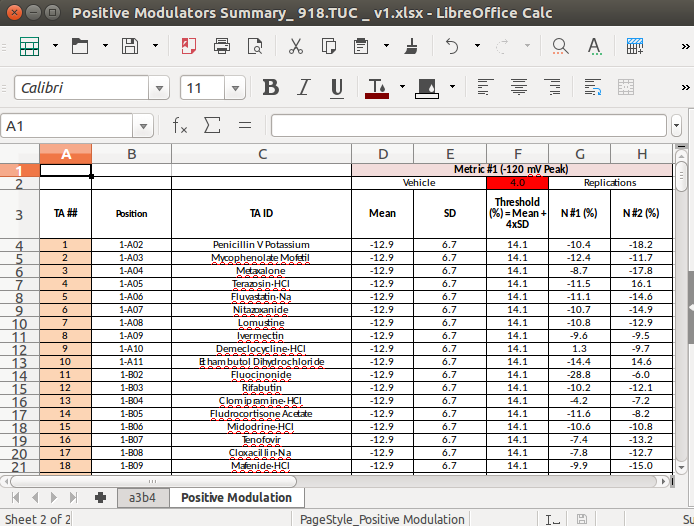

In [ ]:
# We will now look at a screenshot of the dataset of interest, as rendered by LibreOffice
# To do this, we will import Image and OS
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/assets/dataset_preparation_gui.png

import os
from IPython.display import Image, display

current_dir = os.path.dirname(os.path.realpath('__file__'))
data_screenshot = os.path.join(current_dir, 'dataset_preparation_gui.png')
display(Image(filename=data_screenshot))

We see the data of interest is on the second sheet, and contained in columns "TA ID", "N #1 (%)", and "N #2 (%)".

Additionally, it appears much of this spreadsheet was formatted for human readability (multicolumn headers, column labels with spaces and symbols, etc.). This makes the creation of a neat dataframe object harder. For this reason we will cut everything that is unnecesary or inconvenient.

In [ ]:
import deepchem as dc

dc.utils.download_url('https://github.com/deepchem/deepchem/raw/master/datasets/Positive%20Modulators%20Summary_%20918.TUC%20_%20v1.xlsx',
                      current_dir,
                      'Positive Modulators Summary_ 918.TUC _ v1.xlsx')

In [ ]:
raw_data_file = os.path.join(current_dir, 'Positive Modulators Summary_ 918.TUC _ v1.xlsx')
raw_data_excel = pd.ExcelFile(raw_data_file)

# second sheet only
raw_data = raw_data_excel.parse(raw_data_excel.sheet_names[1])

In [ ]:
# preview 5 rows of raw dataframe
raw_data.loc[raw_data.index[:5]]

Unnamed: 0 Unnamed: 1  ...    Unnamed: 6 Unnamed: 7
0        NaN        NaN  ...  Replications        NaN
1      TA ##   Position  ...      N #1 (%)   N #2 (%)
2          1      1-A02  ...       -10.404   -18.1929
3          2      1-A03  ...      -12.4453   -11.7175
4          3      1-A04  ...      -8.65572   -17.7753

[5 rows x 8 columns]

In [ ]:
# remove column label (rows 0 and 1), as we will replace them
# only take data given in columns "TA ID" "N #1 (%)" (3) and "N #2 (%)" (4)
raw_data = raw_data.iloc[2:, [2, 6, 7]]

# reset the index so we keep the label but number from 0 again
raw_data.reset_index(inplace=True)

## rename columns
raw_data.columns = ['label', 'drug', 'n1', 'n2']

In [ ]:
# preview cleaner dataframe
raw_data.loc[raw_data.index[:5]]

label                    drug       n1       n2
0      2  Penicillin V Potassium  -10.404 -18.1929
1      3   Mycophenolate Mofetil -12.4453 -11.7175
2      4              Metaxalone -8.65572 -17.7753
3      5           Terazosin·HCl -11.5048  16.0825
4      6          Fluvastatin·Na -11.1354  -14.553

This formatting is closer to what we need.

Now, let's take the drug names and get smiles strings for them (format needed for DeepChem).

In [ ]:
drugs = raw_data['drug'].values

For many of these, we can retreive the smiles string via the <code>canonical_smiles</code> attribute of the <code>get_compounds</code> object (using pubchempy)

In [ ]:
# Retrieve smiles string via canonical_smiles attribute of the get_compounds object (using pubchempy)
get_compounds(drugs[1], 'name')

[Compound(5281078)]

In [ ]:
get_compounds(drugs[1], 'name')[0].canonical_smiles

'CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3CCOCC3)O'

However, some of these drug names have variables spaces and symbols (·, (±), etc.), and names that may not be readable by pubchempy.

For this task, we will do a bit of hacking via regular expressions. Also, we notice that all ions are written in a shortened form that will need to be expanded. For this reason we use a dictionary, mapping the shortened ion names to versions recognizable to pubchempy.

Unfortunately you may have several corner cases that will require more hacking.

In [ ]:
import re

ion_replacements = {
    'HBr': ' hydrobromide',
    '2Br': ' dibromide',
    'Br': ' bromide',
    'HCl': ' hydrochloride',
    '2H2O': ' dihydrate',
    'H2O': ' hydrate',
    'Na': ' sodium'
}

ion_keys = ['H2O', 'HBr', 'HCl', '2Br', '2H2O', 'Br', 'Na']

def compound_to_smiles(cmpd):
    # remove spaces and irregular characters
    compound = re.sub(r'([^\s\w]|_)+', '', cmpd)

    # replace ion names if needed
    for ion in ion_keys:
        if ion in compound:
            compound = compound.replace(ion, ion_replacements[ion])

    # query for cid first in order to avoid timeouterror
    cid = get_cids(compound, 'name')[0]
    smiles = get_compounds(cid)[0].canonical_smiles

    return smiles

Now let's actually convert all these compounds to smiles. This conversion will take a few minutes so might not be a bad spot to go grab a coffee or tea and take a break while this is running! Note that this conversion will sometimes fail so we've added some error handling to catch these cases below.

In [ ]:
smiles_map = {}

for i, compound in enumerate(drugs):
    try:
        smiles_map[compound] = compound_to_smiles(compound)
    except:
        print("Errored on %s" % i)
        continue

Errored on 258
Errored on 307
Errored on 393


In [ ]:
smiles_data = raw_data
# map drug name to smiles string
smiles_data['drug'] = smiles_data['drug'].apply(lambda x: smiles_map[x] if x in smiles_map else None)

In [ ]:
# preview smiles data
smiles_data.loc[smiles_data.index[:5]]

label                                               drug       n1       n2
0      2  CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...  -10.404 -18.1929
1      3  CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3C... -12.4453 -11.7175
2      4                     CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C -8.65572 -17.7753
3      5  COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC... -11.5048  16.0825
4      6  CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)... -11.1354  -14.553

### De-noising data

In machine learning, we know that there is no free lunch. You will need to spend time analyzing and understanding your data in order to frame your problem and determine the appropriate model framework. Treatment of your data will depend on the conclusions you gather from this process.

Questions to ask yourself:

* What are you trying to accomplish?
* What is your assay?
* What is the structure of the data?
* Does the data make sense?
* What has been tried previously?

For this project (respectively):

* I would like to build a model capable of predicting the affinity of an arbitrary small molecule drug to a particular ion channel protein
* For an input drug, data describing channel inhibition
* A few hundred drugs, with n=2
* Will need to look more closely at the dataset*
* Nothing on this particular protein

*This will involve plotting, so we will import matplotlib and seaborn. We will also need to look at molecular structures, so we will import rdkit. We will also use the seaborn library which you can install with <code>conda install seaborn</code>.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

from rdkit import Chem, rdBase
from rdkit.Chem import AllChem, Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole

import numpy as np

Our goal is to build a small molecule model, so let's make sure our molecules are all small. This can be approximated by the length of each smiles string.

Text(0, 0.5, 'probability')

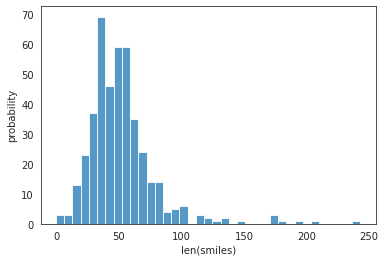

In [ ]:
smiles_data['len'] = [len(i) if i is not None else 0 for i in smiles_data['drug']]
smiles_lens = [len(i) if i is not None else 0 for i in smiles_data['drug']]

sns.histplot(smiles_lens)

plt.xlabel('len(smiles)')
plt.ylabel('probability')

Some of these look rather large, len(smiles) > 150. Let's see what they look like.

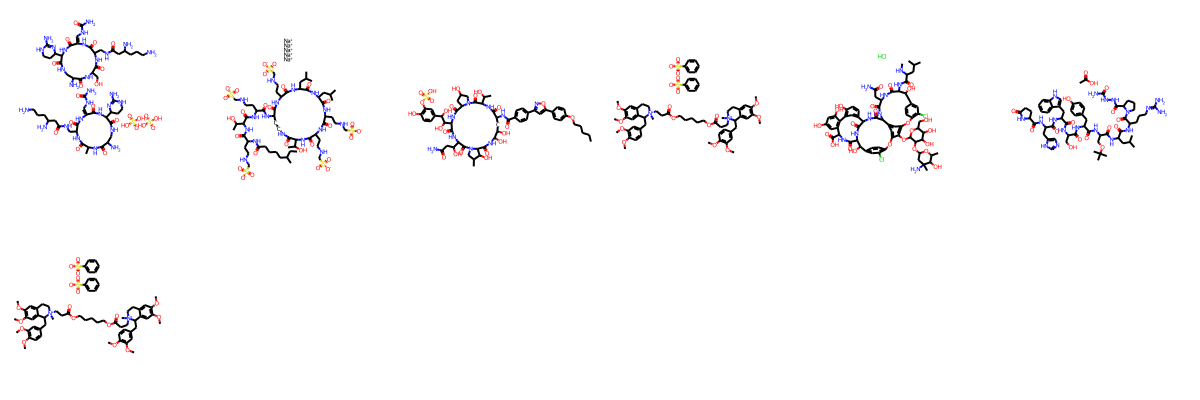

In [ ]:
# indices of large looking molecules
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]

# corresponding smiles string
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['drug'].values

# look
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=6)

As suspected, these are not small molecules, so we will remove them from the dataset. The argument here is that these molecules could register as inhibitors simply because they are large. They are more likely to sterically blocks the channel, rather than diffuse inside and bind (which is what we are interested in).

The lesson here is to remove data that does not fit your use case.

In [ ]:
# drop large molecules 
smiles_data = smiles_data[~smiles_data['drug'].isin(long_smiles)]

Now, let's look at the numerical structure of the dataset.

First, check for NaNs.

In [ ]:
nan_rows = smiles_data[smiles_data.isnull().T.any().T]
nan_rows[['n1', 'n2']]

n1       n2
62       NaN  -7.8266
175      NaN -6.61225
187      NaN -8.23326
233 -8.21781      NaN
258 -6.42199 -4.74996
262      NaN -12.8788
288      NaN -2.34264
300      NaN -8.19936
301      NaN -10.4633
307  2.88362  -7.2908
311      NaN -8.78722
393 -3.10456 -1.64703

I don't trust n=1, so I will throw these out.

Then, let's examine the distribution of n1 and n2.

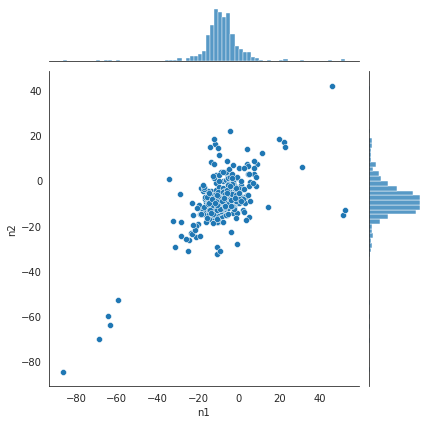

In [ ]:
df = smiles_data.dropna(axis=0, how='any')

# seaborn jointplot will allow us to compare n1 and n2, and plot each marginal
sns.jointplot(x='n1', y='n2', data=smiles_data)

We see that most of the data is contained in the gaussian-ish blob centered a bit below zero. We see that there are a few clearly active datapoints located in the bottom left, and one on the top right. These are all distinguished from the majority of the data. How do we handle the data in the blob?

Because n1 and n2 represent the same measurement, ideally they would be of the same value. This plot should be tightly aligned to the diagonal, and the pearson correlation coefficient should be 1. We see this is not the case. This helps gives us an idea of the error of our assay.

Let's look at the error more closely, plotting in the distribution of (n1-n2).

Text(0, 0.5, 'probability')

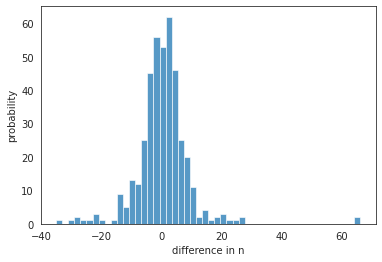

In [ ]:
diff_df = df['n1'] - df['n2']

sns.histplot(diff_df)

plt.xlabel('difference in n')
plt.ylabel('probability')

This looks pretty gaussian, let's get the 95% confidence interval by fitting a gaussian via scipy, and taking 2*the standard deviation

In [ ]:
from scipy import stats

mean, std = stats.norm.fit(np.asarray(diff_df, dtype=np.float32))
ci_95 = std*2
ci_95

17.825611114501953

Now, I don't trust the data outside of the confidence interval, and will therefore drop these datapoints from df.

For example, in the plot above, at least one datapoint has n1-n2 > 60. This is disconcerting.

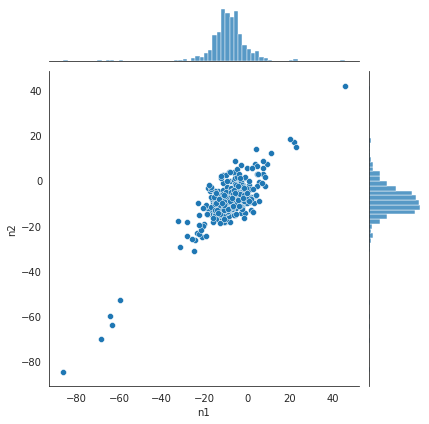

In [ ]:
noisy = diff_df[abs(diff_df) > ci_95]

df = df.drop(noisy.index)
sns.jointplot(x='n1', y='n2', data=df)

Now that data looks much better!

So, let's average n1 and n2, and take the error bar to be ci_95.

In [ ]:
avg_df = df[['label', 'drug']].copy()
n_avg = df[['n1', 'n2']].mean(axis=1)

avg_df['n'] = n_avg
avg_df.sort_values('n', inplace=True)

Now, let's look at the sorted data with error bars.

Text(0, 0.5, 'activity')

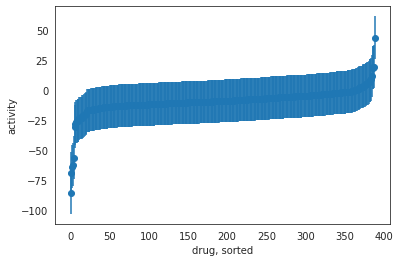

In [ ]:
plt.errorbar(np.arange(avg_df.shape[0]), avg_df['n'], yerr=ci_95, fmt='o')

plt.xlabel('drug, sorted')
plt.ylabel('activity')

Now, let's identify our active compounds.

In my case, this required domain knowledge. Having worked in this area, and having consulted with professors specializing on this channel, I am interested in compounds where the absolute value of the activity is greater than 25. This relates to the desired drug potency we would like to model.

If you are not certain how to draw the line between active and inactive, this cutoff could potentially be treated as a hyperparameter.

<ErrorbarContainer object of 3 artists>

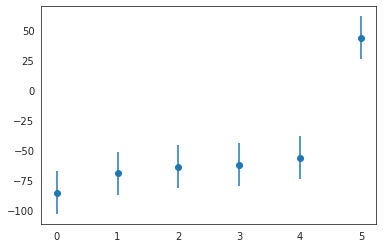

In [ ]:
actives = avg_df[abs(avg_df['n'])-ci_95 > 25]['n']

plt.errorbar(np.arange(actives.shape[0]), actives, yerr=ci_95, fmt='o')

In [ ]:
# summary
print(raw_data.shape, avg_df.shape, len(actives.index))

(430, 5) (390, 3) 6


In summary, we have:

* Removed data that did not address the question we hope to answer (small molecules only)
* Dropped NaNs
* Determined the noise of our measurements
* Removed exceptionally noisy datapoints
* Identified actives (using domain knowledge to determine a threshold)

### Determine model type, final form of dataset, and sanity load

Now, what model framework should we use?

Given that we have 392 datapoints and 6 actives, this data will be used to build a low data one-shot classifier (10.1021/acscentsci.6b00367). If there were datasets of similar character, transfer learning could potentially be used, but this is not the case at the moment.

Let's apply logic to our dataframe in order to cast it into a binary format, suitable for classification.

In [ ]:
# 1 if condition for active is met, 0 otherwise
avg_df.loc[:, 'active'] = (abs(avg_df['n'])-ci_95 > 25).astype(int)

Now, save this to file.

In [ ]:
avg_df.to_csv('modulators.csv', index=False)

Now, we will convert this dataframe to a DeepChem dataset.

In [ ]:
dataset_file = 'modulators.csv'
task = ['active']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='drug', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

Lastly, it is often advantageous to numerically transform the data in some way. For example, sometimes it is useful to normalize the data, or to zero the mean. This depends in the task at hand.

Built into DeepChem are many useful transformers, located in the deepchem.transformers.transformers base class.

Because this is a classification model, and the number of actives is low, I will apply a balancing transformer. I treated this transformer as a hyperparameter when I began training models. It proved to unambiguously improve model performance.

In [ ]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

Now let's save the balanced dataset object to disk, and then reload it as a sanity check.

In [ ]:
dc.utils.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.load_from_disk('balanced_dataset.joblib')

## Putting Multitask Learning to Work

This notebook walks through the creation of multitask models on MUV [1]. The goal is to demonstrate how multitask methods can provide improved performance in situations with little or very unbalanced data.

The MUV dataset is a challenging benchmark in molecular design that consists of 17 different "targets" where there are only a few "active" compounds per target. There are 93,087 compounds in total, yet no task has more than 30 active compounds, and many have even less. Training a model with such a small number of positive examples is very challenging. Multitask models address this by training a single model that predicts all the different targets at once. If a feature is useful for predicting one task, it often is useful for predicting several other tasks as well. Each added task makes it easier to learn important features, which improves performance on other tasks [2].

To get started, let's load the MUV dataset. The MoleculeNet loader function automatically splits it into training, validation, and test sets. Because there are so few positive examples, we use stratified splitting to ensure the test set has enough of them to evaluate.

In [ ]:
import deepchem as dc
import numpy as np

tasks, datasets, transformers = dc.molnet.load_muv(splitter='stratified')
train_dataset, valid_dataset, test_dataset = datasets

Now let's train a model on it. We'll use a MultitaskClassifier, which is a simple stack of fully connected layers.

In [ ]:
n_tasks = len(tasks)
n_features = train_dataset.get_data_shape()[0]

model = dc.models.MultitaskClassifier(n_tasks, n_features)
model.fit(train_dataset)

0.18295688629150392

Let's see how well it does on the test set. We loop over the 17 tasks and compute the ROC AUC for each one.

In [ ]:
y_true = test_dataset.y
y_pred = model.predict(test_dataset)
metric = dc.metrics.roc_auc_score

for i in range(n_tasks):
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    print(tasks[i], score)

MUV-466 0.3126097080422712
MUV-548 0.7478237506716819
MUV-600 0.5373186458893068
MUV-644 0.847322228192728
MUV-652 0.2253179294286226
MUV-689 0.8757209385634963
MUV-692 0.6755776464266523
MUV-712 0.908113917248791
MUV-713 0.5952265806913846
MUV-733 0.672622246104245
MUV-737 0.19971341572631202
MUV-810 0.7334587139530718
MUV-832 0.9837368336199483
MUV-846 0.9701862797778972
MUV-852 0.8197384918502597
MUV-858 0.7313630664517285
MUV-859 0.49390178379540084


Not bad! Recall that random guessing would produce a ROC AUC score of 0.5, and a perfect predictor would score 1.0. Most of the tasks did much better than random guessing, and many of them are above 0.9.

## Modeling Protein-Ligand Interactions

In this tutorial, we'll walk you through the use of machine learning and molecular docking methods to predict the binding energy of a protein-ligand complex. Recall that a ligand is some small molecule which interacts (usually non-covalently) with a protein. Molecular docking performs geometric calculations to find a “binding pose” with a small molecule interacting with a protein in a suitable binding pocket (that is, a region on the protein which has a groove in which the small molecule can rest).

The structure of proteins can be determined experimentally with techniques like Cryo-EM or X-ray crystallography. This can be a powerful tool for structure-based drug discovery. For more info on docking, read the AutoDock Vina paper and the deepchem.dock documentation. There are many graphical user and command line interfaces (like AutoDock) for performing molecular docking. Here, we show how docking can be performed programmatically with DeepChem, which enables automation and easy integration with machine learning pipelines.

As you work through the tutorial, you'll trace an arc including

1. Loading a protein-ligand complex dataset (PDBbind)
2. Performing programmatic molecular docking
3. Featurizing protein-ligand complexes with interaction fingerprints
4. Fitting a random forest model and predicting binding affinities

To start the tutorial, we'll use a simple pre-processed dataset file that comes in the form of a gzipped file. Each row is a molecular system, and each column represents a different piece of information about that system. For instance, in this example, every row reflects a protein-ligand complex, and the following columns are present: a unique complex identifier; the SMILES string of the ligand; the binding affinity (Ki) of the ligand to the protein in the complex; a Python list of all lines in a PDB file for the protein alone; and a Python list of all lines in a ligand file for the ligand alone.

### Protein-ligand complex data

It is really helpful to visualize proteins and ligands when doing docking. Unfortunately, Google Colab doesn't currently support the Jupyter widgets we need to do that visualization. Install MDTraj and nglview on your local machine to view the protein-ligand complexes we're working with.

In [ ]:
!pip install -q mdtraj nglview
!jupyter-nbextension enable nglview --py --sys-prefix  # for jupyter notebook

In [ ]:
import os
import numpy as np
import pandas as pd

import tempfile

from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc

from deepchem.utils import download_url, load_from_disk

To illustrate the docking procedure, here we'll use a csv that contains SMILES strings of ligands as well as PDB files for the ligand and protein targets from PDBbind. Later, we'll use the labels to train a model to predict binding affinities. We'll also show how to download and featurize PDBbind to train a model from scratch.

In [ ]:
data_dir = dc.utils.get_data_dir()
dataset_file = os.path.join(data_dir, "pdbbind_core_df.csv.gz")

if not os.path.exists(dataset_file):
    print('File does not exist. Downloading file...')
    download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/pdbbind_core_df.csv.gz")
    print('File downloaded...')

raw_dataset = load_from_disk(dataset_file)
raw_dataset = raw_dataset[['pdb_id', 'smiles', 'label']]

File does not exist. Downloading file...
File downloaded...


Let's see what <code>raw_dataset</code> looks like:

In [ ]:
raw_dataset.head(2)

pdb_id                                             smiles  label
0   2d3u        CC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   6.92
1   3cyx  CC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1CCCCC...   8.00

### Fixing PDB files

Next, let's get some PDB protein files for visualization and docking. We'll use the PDB IDs from our <code>raw_dataset</code> and download the pdb files directly from the Protein Data Bank using <code>pdbfixer</code>. We'll also sanitize the structures with RDKit. This ensures that any problems with the protein and ligand files (non-standard residues, chemical validity, etc.) are corrected. Feel free to modify these cells and pdbids to consider new protein-ligand complexes. We note here that PDB files are complex and human judgement is required to prepare protein structures for docking. DeepChem includes a number of docking utilites to assist you with preparing protein files, but results should be inspected before docking is attempted.

In [ ]:
from simtk.openmm.app import PDBFile
from pdbfixer import PDBFixer

from deepchem.utils.vina_utils import prepare_inputs

In [ ]:
# consider one protein-ligand complex for visualization
pdbid = raw_dataset['pdb_id'].iloc[1]
ligand = raw_dataset['smiles'].iloc[1]

In [ ]:
%%time 
fixer = PDBFixer(pdbid=pdbid)
PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))

p, m = None, None
# fix protein, optimize ligand geometry, and sanitize molecules
try:
    p, m = prepare_inputs('%s.pdb' % (pdbid), ligand)
except:
    print('%s failed PDB fixing' % (pdbid))

if p and m: # protein and molecule are readable by RDKit
    print(pdbid, p.GetNumAtoms())
    Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
    Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  import sys


3cyx 1415
CPU times: user 3.32 s, sys: 313 ms, total: 3.64 s
Wall time: 7.27 s


### Visualization

If you're outside of Colab, you can expand these cells and use <code>MDTraj</code> and <code>nglview</code> to visualize proteins and ligands.

In [ ]:
import mdtraj as md
import nglview

from IPython.display import display, Image

Let's take a look at the first protein ligand pair in our dataset:

In [ ]:
protein_mdtraj = md.load_pdb('3cyx.pdb')
ligand_mdtraj = md.load_pdb('ligand_3cyx.pdb')

We'll use the convenience function <code>nglview.show_mdtraj</code> in order to view our proteins and ligands. Note that this will only work if you uncommented the above cell, installed nglview, and enabled the necessary notebook extensions.

In [ ]:
# We'll use the convenience function nglview.show_mdtraj to view our protein and ligands
v = nglview.show_mdtraj(ligand_mdtraj)

In [ ]:
display(v) # interactive view outside Colab

NGLWidget()

Now that we have an idea of what the ligand looks like, let's take a look at our protein:

In [ ]:
view = nglview.show_mdtraj(protein_mdtraj)
display(view) # interactive view outside Colab

NGLWidget()

### Molecular Docking

Ok, now that we've got our data and basic visualization tools up and running, let's see if we can use molecular docking to estimate the binding affinities between our protein ligand systems.

There are three steps to setting up a docking job, and you should experiment with different settings. The three things we need to specify are 1) how to identify binding pockets in the target protein; 2) how to generate poses (geometric configurations) of a ligand in a binding pocket; and 3) how to "score" a pose. Remember, our goal is to identify candidate ligands that strongly interact with a target protein, which is reflected by the score.

DeepChem has a simple built-in method for identifying binding pockets in proteins. It is based on the convex hull method. The method works by creating a 3D polyhedron (convex hull) around a protein structure and identifying the surface atoms of the protein as the ones closest to the convex hull. Some biochemical properties are considered, so the method is not purely geometrical. It has the advantage of having a low computational cost and is good enough for our purposes.

In [ ]:
finder = dc.dock.binding_pocket.ConvexHullPocketFinder()
pockets = finder.find_pockets('3cyx.pdb')
len(pockets) # number of identified pockets

37

Pose generation is quite complex. Luckily, using DeepChem's pose generator will install the AutoDock Vina engine under the hood, allowing us to get up and running generating poses quickly.

In [ ]:
vpg = dc.dock.pose_generation.VinaPoseGenerator()

We could specify a pose scoring function from <code>deepchem.dock.pose_scoring</code>, which includes things like repulsive and hydrophobic interactions and hydrogen bonding. Vina will take care of this, so instead we'll allow Vina to compute scores for poses.

In [ ]:
!mkdir -p vina_test

In [ ]:
%%time
complexes, scores = vpg.generate_poses(molecular_complex=('3cyx.pdb', 'ligand_3cyx.pdb'), # protein-ligand files for docking
                                       out_dir='vina_test',
                                       generate_scores=True)

Mol [H]OC1=C([H])C([H])=C(C([H])([H])[C@@]2([H])C(=O)N([H])[C@@]([H])(C([H])([H])C(=O)O)C(=O)N([H])[C@@]([H])(C([H])([H])C([H])([H])C(=O)N([H])[H])C(=O)N([H])[C@@]([H])([C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C(=O)N([H])[C@@]([H])([C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N3C([H])([H])C([H])([H])C([H])([H])[C@@]3([H])C(=O)N([H])[C@]([H])(C(=O)N3C([H])([H])C([H])([H])C([H])([H])[C@@]3([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])

CPU times: user 8.63 s, sys: 1.49 s, total: 10.1 s
Wall time: 15min


We used the default value for num_modes when generating poses, so Vina will return the 9 lowest energy poses it found in units of kcal/mol.

In [ ]:
scores

[-9.0, -8.9, -8.8, -8.7, -8.6, -8.6, -8.5, -8.5, -8.5]

Can we view the complex with both protein and ligand? Yes, but we'll need to combine the molecules into a single RDkit molecule.

In [ ]:
complex_mol = Chem.CombineMols(complexes[0][0], complexes[0][1])

Let's now visualize our complex. We can see that the ligand slots into a pocket of the protein.

In [ ]:
v = nglview.show_rdkit(complex_mol)
display(v)

NGLWidget()

Now that we understand each piece of the process, we can put it all together using DeepChem's Docker class. Docker creates a generator that yields tuples of posed complexes and docking scores.

In [ ]:
docker = dc.dock.docking.Docker(pose_generator=vpg)
posed_complex, score = next(docker.dock(molecular_complex=('3cyx.pdb', 'ligand_3cyx.pdb'),
                                        use_pose_generator_scores=True))

Mol [H]OC1=C([H])C([H])=C(C([H])([H])[C@@]2([H])C(=O)N([H])[C@@]([H])(C([H])([H])C(=O)O)C(=O)N([H])[C@@]([H])(C([H])([H])C([H])([H])C(=O)N([H])[H])C(=O)N([H])[C@@]([H])([C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C(=O)N([H])[C@@]([H])([C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N3C([H])([H])C([H])([H])C([H])([H])[C@@]3([H])C(=O)N([H])[C@]([H])(C(=O)N3C([H])([H])C([H])([H])C([H])([H])[C@@]3([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])

### Modeling Binding Affinity

Docking is a useful, albeit coarse-grained tool for predicting protein-ligand binding affinities. However, it takes some time, especially for large-scale virtual screenings where we might be considering different protein targets and thousands of potential ligands. We might naturally ask then, can we train a machine learning model to predict docking scores? Let's try and find out!

We'll show how to download the PDBbind dataset. We can use the loader in MoleculeNet to get the 4852 protein-ligand complexes from the "refined" set or the entire "general" set in PDBbind. For simplicity, we'll stick with the ~100 complexes we've already processed to train our models.

Next, we'll need a way to transform our protein-ligand complexes into representations which can be used by learning algorithms. Ideally, we'd have neural protein-ligand complex fingerprints, but DeepChem doesn't yet have a good learned fingerprint of this sort. We do however have well-tuned manual featurizers that can help us with our challenge here.

We'll make use of two types of fingerprints in the rest of the tutorial, the <code>CircularFingerprint</code> and <code>ContactCircularFingerprint</code>. DeepChem also has voxelizers and grid descriptors that convert a 3D volume containing an arragment of atoms into a fingerprint. These featurizers are really useful for understanding protein-ligand complexes since they allow us to translate complexes into vectors that can be passed into a simple machine learning algorithm. First, we'll create circular fingerprints. These convert small molecules into a vector of fragments.

In [ ]:
pdbids = raw_dataset['pdb_id'].values
ligand_smiles = raw_dataset['smiles'].values

In [ ]:
%%time 
for (pdbid, ligand) in zip(pdbids, ligand_smiles):
    fixer = PDBFixer(url='https://files.rcsb.org/download/%s.pdb' % (pdbid))
    PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))

    p, m = None, None
    # skip pdb fixing for speed
    try:
        p, m = prepare_inputs('%s.pdb' % (pdbid), ligand, replace_nonstandard_residues=False,
                              remove_heterogens=False, remove_water=False,
                              add_hydrogens=False)
    except:
        print('%s failed sanitization' % (pdbid))
    
    if p and m: # protein and molecule are readable by RDKit
        Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
        Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

In [ ]:
proteins = [f for f in os.listdir('.') if len(f) == 8 and f.endswith('.pdb')]
ligands = [f for f in os.listdir('.') if f.startswith('ligand') and f.endswith('.pdb')]

We'll do some clean up to make sure we have a valid ligand file for every valid protein. The lines here will compare the PDB IDs between the ligand and protein files and remove any proteins that don't have corresponding ligands.

In [ ]:
# Handle failed sanitizations
failures = set([f[:-4] for f in proteins]) - set([f[7:-4] for f in ligands])

for pdbid in failures:
    proteins.remove(pdbid + '.pdb')

In [ ]:
len(proteins), len(ligands)

(190, 190)

In [ ]:
pdbids = [f[:-4] for f in proteins]
small_dataset = raw_dataset[raw_dataset['pdb_id'].isin(pdbids)]
labels = small_dataset.label

In [ ]:
fp_featurizer = dc.feat.CircularFingerprint(size=2048)

In [ ]:
features = fp_featurizer.featurize([Chem.MolFromPDBFile(l) for l in ligands])

In [ ]:
dataset = dc.data.NumpyDataset(X=features, y=labels, ids=pdbids)
train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=42)

The convenience loader <code>dc.molnet.load_pdbbind</code> will take care of downloading and featurizing the pdbbind dataset under the hood for us. This will take quite a bit of time and compute, so the code to do it is commented out. Uncomment it and grab a cup of coffee if you'd like to featurize all of PDBbind's refined set. Otherwise, you can continue with the small dataset we constructed above.

In [3]:
# # Uncomment to featurize all of PDBBind's "refined" set
# pdbbind_tasks, (train_dataset, valid_dataset, test_dataset), transformers = dc.molnet.load_pdbbind(
#     featurizer=fp_featurizer, set_name="refined", reload=True,
#     data_dir='pdbbind_data', save_dir='pdbbind_data')

Now, we're ready to do some learning!

To fit a deepchem model, first we instantiate one of the provided (or user-written) model classes. In this case, we have a created a convenience class to wrap around any ML model available in Sci-Kit Learn that can in turn be used to interoperate with deepchem. To instantiate an <code>SklearnModel</code>, you will need (a) task_types, (b) model_params, another dict as illustrated below, and (c) a <code>model_instance</code> defining the type of model you would like to fit, in this case a <code>RandomForestRegressor</code>.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

from deepchem.utils.evaluate import Evaluator
import pandas as pd

In [ ]:
seed = 42 # Set a random seed to get stable results

sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed

model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

Note that the $R^2$ value for the test set indicates that the model isn't producing meaningful outputs. It turns out that predicting binding affinities is hard. This tutorial isn't meant to show how to create a state-of-the-art model for predicting binding affinities, but it gives you the tools to generate your own datasets with molecular docking, featurize complexes, and train models.

In [ ]:
# use Pearson correlation so metrics are > 0
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train_dataset, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test_dataset, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

RF Train set R^2 0.897679
RF Test set R^2 0.000003


We're using a very small dataset and an overly simplistic representation, so it's no surprise that the test set performance is quite bad.

In [ ]:
# Compare predicted and true values
list(zip(model.predict(train_dataset), train_dataset.y))[:5]

[(7.313499999999993, 7.4),
 (6.307160000000009, 6.85),
 (4.761399999999993, 3.4),
 (6.74453333333334, 6.72),
 (9.109199999999989, 11.06)]

In [ ]:
list(zip(model.predict(test_dataset), test_dataset.y))[:5]

[(6.883733333333332, 4.21),
 (5.811958333333337, 8.7),
 (6.292429761904762, 6.39),
 (5.001775000000004, 4.94),
 (6.418366666666672, 9.21)]

### The protein-ligand complex view.

In the previous section, we featurized only the ligand. This time, let's see if we can do something sensible with our protein-ligand fingerprints that make use of our structural information. To start with, we need to re-featurize the dataset but using the contact fingerprint this time.

In [ ]:
fp_featurizer = dc.feat.ContactCircularFingerprint(size=2048)

In [ ]:
features = fp_featurizer.featurize(zip(ligands, proteins))
dataset = dc.data.NumpyDataset(X=features, y=labels, ids=pdbids)

train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=42)

Mol CCCCCCCCCCCCCC.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C

Let's now train a simple random forest model on this dataset.

In [ ]:
seed = 42 # Set a random seed to get stable results

sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed

model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

Let's see what our accuracies looks like!

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train_dataset, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test_dataset, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

RF Train set R^2 0.433438
RF Test set R^2 0.007598


Ok, it looks like we have lower accuracy than the ligand-only dataset. Nonetheless, it's probably still useful to have a protein-ligand model since it's likely to learn different features than the the pure ligand-only model.

## Modeling Protein-Ligand Interactions with Atomic Convolutions

This DeepChem tutorial introduces the Atomic Convolutional Neural Network. We'll see the structure of the AtomicConvModel and write a simple program to run Atomic Convolutions.
The atom type convolution makes use of a neighbor-listed distance matrix to extract features encoding local chemical environments from an input representation that does not necessarily contain spatial locality. The following methods are used to build the ACNN architecture:

### ACNN Architecture

ACNN’s directly exploit the local three-dimensional structure of molecules to hierarchically learn more complex chemical features by optimizing both the model and featurization simultaneously in an end-to-end fashion.

The atom type convolution makes use of a neighbor-listed distance matrix to extract features encoding local chemical environments from an input representation (Cartesian atomic coordinates) that does not necessarily contain spatial locality. The following methods are used to build the ACNN architecture:

* <b>Distance Matrix</b>

    The distance matrix <i>R</i> is constructed from the Cartesian atomic coordinates <i>X</i>. It calculates distances from the distance tensor <i>D</i>. The distance matrix construction accepts as input a (<i>N</i>, 3) coordinate matrix <i>C</i>. This matrix is "neighbor listed" into a (<i>N, M</i>) matrix <i>R</i>.

    <code>R = tf.reduce_sum(tf.multiply(D, D), 3)</code>      
    <code>R = tf.sqrt(R)</code>  
    <code>return R</code>
    

* <b>Atom type convolution</b>

    The output of the atom type convolution is constructed from the distance matrix <i>R</i> and atomic number matrix <i>Z</i>. The matrix <i>R</i> is fed into a (1x1) filter with stride 1 and depth of <i>N<sub>at</i>, where <i>N<sub>at</i> is the number of unique atomic numbers (atom types) present in the molecular system. The atom type convolution kernel is a step function that operates on the neighbor distance matrix <i>R</i>.
    

* <b>Radial Pooling layer</b>

    Radial Pooling is basically a dimensionality reduction process that down-samples the output of the atom type convolutions. The reduction process prevents overfitting by providing an abstracted form of representation through feature binning, as well as reducing the number of parameters learned. Mathematically, radial pooling layers pool over tensor slices (receptive fields) of size (1x<i>M</i>x1) with stride 1 and a depth of <i>N<sub>r</i> where <i>N<sub>r</i> is the number of desired radial filters and <i>M</i> is the maximum number of neighbors.
    

* <b>Atomistic fully connected network</b>

    Atomic Convolution layers are stacked by feeding the flattened (<i>N, N<sub>at</i> * <i>N<sub>r</i>) output of the radial pooling layer into the atom type convolution operation. Finally, we feed the tensor row-wise (per-atom) into a fully-connected network. The same fully connected weights and biases are used for each atom in a given molecule.

Since we've seen the structural overview of ACNNs, we'll try to get deeper into the model and see how we can train it and what we expect as the output. For the training, we will use the publicly available PDBbind dataset. In this example, every row reflects a protein-ligand complex and the target is the binding affinity (<i>K<sub>i</i>) of the ligand to the protein in the complex.

In [ ]:
!/root/miniconda/bin/conda install -c conda-forge mdtraj -y -q  # needed for AtomicConvs

In [ ]:
import deepchem as dc
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from rdkit import Chem

from deepchem.molnet import load_pdbbind
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

#### Getting protein-ligand data

If you worked through the tutorial on modeling protein-ligand interactions, you'll already be familiar with how to obtain a set of data from PDBbind for training our model. Since we explored molecular complexes in detail in the previous tutorial), this time we'll simply initialize an AtomicConvFeaturizer and load the PDBbind dataset directly using MolNet.

In [ ]:
f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000 # maximum number of atoms to consider in the protein
max_num_neighbors = 12 # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                           frag2_num_atoms=f2_num_atoms,
                           complex_num_atoms=f1_num_atoms+f2_num_atoms,
                           max_num_neighbors=max_num_neighbors,
                           neighbor_cutoff=4)

<code>load_pdbbind</code> allows us to specify if we want to use the entire protein or only the binding pocket (<code>pocket=True</code>) for featurization. Using only the pocket saves memory and speeds up the featurization. We can also use the "core" dataset of ~200 high-quality complexes for rapidly testing our model, or the larger "refined" set of nearly 5000 complexes for more datapoints and more robust training/validation. On Colab, it takes only a minute to featurize the core PDBbind set! This is pretty incredible, and it means you can quickly experiment with different featurizations and model architectures.

In [ ]:
%%time
tasks, datasets, transformers = load_pdbbind(featurizer=acf,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


CPU times: user 45.4 s, sys: 19.8 s, total: 1min 5s
Wall time: 1min 7s


In [ ]:
datasets

(<DiskDataset X.shape: (154, 9), y.shape: (154,), w.shape: (154,), ids: ['1bcu' '2zcr' '2qft' ... '2wbg' '1a30' '4des'], task_names: [0]>,
 <DiskDataset X.shape: (19, 9), y.shape: (19,), w.shape: (19,), ids: ['3gcs' '1nvq' '2weg' ... '2brb' '4gid' '3gbb'], task_names: [0]>,
 <DiskDataset X.shape: (20, 9), y.shape: (20,), w.shape: (20,), ids: ['2obf' '2vl4' '3ueu' ... '2d3u' '2v00' '3bkk'], task_names: [0]>)

In [ ]:
train, val, test = datasets

#### Training the model

Now that we've got our dataset, let's go ahead and initialize an <code>AtomicConvModel</code> to train. Keep the input parameters the same as those used in <code>AtomicConvFeaturizer</code>, or else we'll get errors. <code>layer_sizes</code> controls the number of layers and the size of each dense layer in the network. We choose these hyperparameters to be the same as those used in the original paper.

In [ ]:
acm = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=12,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003)

In [ ]:
losses, val_losses = [], []

In [ ]:
%%time 
max_epochs = 50

for epoch in range(max_epochs):
    loss = acm.fit(train, nb_epoch=1, max_checkpoints_to_keep=1, all_losses=losses)
    metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    val_losses.append(acm.evaluate(val, metrics=[metric])['rms_score']**2) # L2 Loss

CPU times: user 7min 44s, sys: 50.2 s, total: 8min 34s
Wall time: 9min 3s


The loss curves are not exactly smooth, which is unsurprising because we are using 154 training and 19 validation datapoints. Increasing the dataset size may help with this, but will also require greater computational resources.

In [ ]:
f, ax = plt.subplots()

ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')

plt.legend(loc='upper right');

The ACNN paper showed a Pearson $R^2$ score of 0.912 and 0.448 for a random 80/20 split of the PDBbind core train/test sets. Here, we've used an 80/10/10 training/validation/test split and achieved similar performance for the training set (0.943). We can see from the performance on the training, validation, and test sets (and from the results in the paper) that the ACNN can learn chemical interactions from small training datasets, but struggles to generalize. Still, it is pretty amazing that we can train an <code>AtomicConvModel</code> with only a few lines of code and start predicting binding affinities!
From here, you can experiment with different hyperparameters, more challenging splits, and the "refined" set of PDBbind to see if you can reduce overfitting and come up with a more robust model.

In [ ]:
score = dc.metrics.Metric(dc.metrics.score_function.pearson_r2_score)

for tvt, ds in zip(['train', 'val', 'test'], datasets):
    print(tvt, acm.evaluate(ds, metrics=[score]))

train {'pearson_r2_score': 0.9369657032075531}
val {'pearson_r2_score': 0.47834949363467955}
test {'pearson_r2_score': 0.422937736527442}


## Learning Unsupervised Embeddings for Molecules

In this tutorial, we will use a SeqToSeq model to generate fingerprints for classifying molecules. This is based on the following paper, although some of the implementation details are different: Xu et al., "Seq2seq Fingerprint: An Unsupervised Deep Molecular Embedding for Drug Discovery" (https://doi.org/10.1145/3107411.3107424).

### Learning Embeddings with SeqToSeq¶

Many types of models require their inputs to have a fixed shape. Since molecules can vary widely in the numbers of atoms and bonds they contain, this makes it hard to apply those models to them. We need a way of generating a fixed length "fingerprint" for each molecule. Various ways of doing this have been designed, such as the Extended-Connectivity Fingerprints (ECFPs) we used in earlier tutorials. But in this example, instead of designing a fingerprint by hand, we will let a <code>SeqToSeq</code> model learn its own method of creating fingerprints.

A <code>SeqToSeq</code> model performs sequence to sequence translation. For example, they are often used to translate text from one language to another. It consists of two parts called the "encoder" and "decoder". The encoder is a stack of recurrent layers. The input sequence is fed into it, one token at a time, and it generates a fixed length vector called the "embedding vector". The decoder is another stack of recurrent layers that performs the inverse operation: it takes the embedding vector as input, and generates the output sequence. By training it on appropriately chosen input/output pairs, you can create a model that performs many sorts of transformations.

In this case, we will use SMILES strings describing molecules as the input sequences. We will train the model as an autoencoder, so it tries to make the output sequences identical to the input sequences. For that to work, the encoder must create embedding vectors that contain all information from the original sequence. That's exactly what we want in a fingerprint, so perhaps those embedding vectors will then be useful as a way to represent molecules in other models!

Let's start by loading the data. We will use the MUV dataset. It includes 74,501 molecules in the training set, and 9313 molecules in the validation set, so it gives us plenty of SMILES strings to work with.

In [ ]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_muv(splitter='stratified')
train_dataset, valid_dataset, test_dataset = datasets

train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids

We need to define the "alphabet" for our <code>SeqToSeq</code> model, the list of all tokens that can appear in sequences. (It's also possible for input and output sequences to have different alphabets, but since we're training it as an autoencoder, they're identical in this case.) Make a list of every character that appears in any training sequence.

In [ ]:
tokens = set()

for s in train_smiles:
    tokens = tokens.union(set(c for c in s))
    
tokens = sorted(list(tokens))

Create the model and define the optimization method to use. In this case, learning works much better if we gradually decrease the learning rate. We use an <code>ExponentialDecay</code> to multiply the learning rate by 0.9 after each epoch.

In [ ]:
from deepchem.models.optimizers import Adam, ExponentialDecay

max_length = max(len(s) for s in train_smiles)
batch_size = 100
batches_per_epoch = len(train_smiles)/batch_size

model = dc.models.SeqToSeq(tokens,
                           tokens,
                           max_length,
                           encoder_layers=2,
                           decoder_layers=2,
                           embedding_dimension=256,
                           model_dir='fingerprint',
                           batch_size=batch_size,
                           learning_rate=ExponentialDecay(0.001, 0.9, batches_per_epoch))

Let's train it! The input to <code>fit_sequences()</code> is a generator that produces input/output pairs. On a good GPU, this should take a few hours or less.

In [ ]:
def generate_sequences(epochs):
    for i in range(epochs):
        for s in train_smiles:
            yield(s, s)

model.fit_sequences(generate_sequences(40))

Let's see how well it works as an autoencoder. We'll run the first 500 molecules from the validation set through it, and see how many of them are exactly reproduced.

In [ ]:
predicted = model.predict_from_sequences(valid_smiles[:500])
count = 0

for s, p in zip(valid_smiles[:500], predicted):
    if ''.join(p) == s:
        count += 1
print('reproduced', count, 'of 500 validation SMILES strings')

reproduced 168 of 500 validation SMILES strings


Now we'll trying using the encoder as a way to generate molecular fingerprints. We compute the embedding vectors for all molecules in the training and validation datasets, and create new datasets that have those as their feature vectors. The amount of data is small enough that we can just store everything in memory.

In [ ]:
import numpy as np

train_embeddings = model.predict_embeddings(train_smiles)
train_embeddings_dataset = dc.data.NumpyDataset(train_embeddings,
                                                train_dataset.y,
                                                train_dataset.w.astype(np.float32),
                                                train_dataset.ids)

valid_embeddings = model.predict_embeddings(valid_smiles)
valid_embeddings_dataset = dc.data.NumpyDataset(valid_embeddings,
                                                valid_dataset.y,
                                                valid_dataset.w.astype(np.float32),
                                                valid_dataset.ids)

For classification, we'll use a simple fully connected network with one hidden layer.

In [ ]:
classifier = dc.models.MultitaskClassifier(n_tasks=len(tasks),
                                           n_features=256,
                                           layer_sizes=[512])
classifier.fit(train_embeddings_dataset, nb_epoch=10)

0.08918972969055176

Find out how well it worked. Compute the ROC AUC for the training and validation datasets.

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")

train_score = classifier.evaluate(train_embeddings_dataset, [metric], transformers)
valid_score = classifier.evaluate(valid_embeddings_dataset, [metric], transformers)

print('Training set ROC AUC:', train_score)
print('Validation set ROC AUC:', valid_score)

Training set ROC AUC: {'mean-roc_auc_score': 0.9814249260039363}
Validation set ROC AUC: {'mean-roc_auc_score': 0.6617702866765572}


## ChemBERTa: Large-Scale Self-Supervised Pretraining for Molecular Property Prediction using a Smiles Tokenization Strategy

Deep learning for chemistry and materials science remains a novel field with lots of potiential. However, the popularity of transfer learning based methods in areas such as natural language processing (NLP) and computer vision have not yet been effectively developed in computational chemistry + machine learning. Using HuggingFace's suite of models and the ByteLevel tokenizer, we are able to train a large-transformer model, RoBERTa, on a large corpus of 10,000,000 SMILES strings from a commonly known benchmark chemistry dataset, PubChem.

Training RoBERTa over 10 epochs, the model achieves a pretty good loss of 0.198, and may likely continue to converge if trained for a larger number of epochs. The model can predict masked/corrupted tokens within a SMILES sequence/molecule, allowing for variants of a molecule within discoverable chemical space to be predicted.

By applying the representations of functional groups and atoms learned by the model, we can try to tackle problems of toxicity, solubility, drug-likeness, and synthesis accessibility on smaller datasets using the learned representations as features for graph convolution and attention models on the graph structure of molecules, as well as fine-tuning of BERT. Finally, we propose the use of attention visualization as a helpful tool for chemistry practitioners and students to quickly identify important substructures in various chemical properties.

Additionally, visualization of the attention mechanism have been seen through previous research as incredibly valuable towards chemical reaction classification. The applications of open-sourcing large-scale transformer models such as RoBERTa with HuggingFace may allow for the acceleration of these individual research directions.

For the sake of this tutorial, we'll be fine-tuning a pre-trained ChemBERTa on a small-scale molecule dataset, Clintox, to show the potiential and effectiveness of HuggingFace's NLP-based transfer learning applied to computational chemistry.

In short, there are three major components we'll be going over in this notebook.

1. Masked token inference predictions on SMILES strings
2. Attention visualizaiton of the PubChem-10M model
3. Fine-tuning BPE-ChemBERTa and Smiles-Tokenizer ChemBERTa model's on the CLintox toxicity dataset.

We want to install NVIDIA's Apex tool, for the training pipeline used by <code>simple-transformers</code> and Weights and Biases. This package enables us to use 16-bit training, mixed precision, and distributed training without any changes to our code. Generally GPUs are good at doing 32-bit(single precision) math, not at 16-bit(half) nor 64-bit(double precision). Therefore traditionally deep learning model trainings are done in 32-bit. By switching to 16-bit, we’ll be using half the memory and theoretically less computation at the expense of the available number range and precision. However, pure 16-bit training creates a lot of problems for us (imprecise weight updates, gradient underflow and overflow). Mixed precision training, with Apex, alleviates these problems.

We will be installing <code>simple-transformers</code>, a library which builds ontop of HuggingFace's transformers package specifically for fine-tuning ChemBERTa.

In [ ]:
!git clone https://github.com/NVIDIA/apex
%cd /content/apex 

!pip install -v --no-cache-dir /content/apex
!pip install transformers simpletransformers wandb

%cd ..

In [2]:
import sys

!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
    
if not 'bertviz_repo' in sys.path:
    sys.path += ['bertviz_repo']
    
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1383, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 1383 (delta 113), reused 118 (delta 61), pack-reused 1203
Receiving objects: 100% (1383/1383), 213.84 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (876/876), done.


We're going to clone an auxillary repository, bert-loves-chemistry, which will enable us to use the MolNet dataloader for ChemBERTa, which automatically generates scaffold splits on any MoleculeNet dataset!

In [3]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 626, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 626 (delta 207), reused 246 (delta 175), pack-reused 339
Receiving objects: 100% (626/626), 47.12 MiB | 24.68 MiB/s, done.
Resolving deltas: 100% (363/363), done.


In [4]:
!nvidia-smi

Wed May 12 14:29:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now, to ensure our model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene.

In [5]:
# Test if NVIDIA apex training tool works
from apex import amp

### What is a tokenizer?

A tokenizer is in charge of preparing the inputs for a natural language processing model. For many scientific applications, it is possible to treat inputs as “words”/”sentences” and use NLP methods to make meaningful predictions. For example, SMILES strings or DNA sequences have grammatical structure and can be usefully modeled with NLP techniques. DeepChem provides some scientifically relevant tokenizers for use in different applications. These tokenizers are based on those from the Huggingface transformers library (which DeepChem tokenizers inherit from).

The base classes PreTrainedTokenizer and PreTrainedTokenizerFast in HuggingFace implements the common methods for encoding string inputs in model inputs and instantiating/saving python tokenizers either from a local file or directory or from a pretrained tokenizer provided by the library (downloaded from HuggingFace’s AWS S3 repository).

PreTrainedTokenizer (transformers.PreTrainedTokenizer)) thus implements the main methods for using all the tokenizers:

* Tokenizing (spliting strings in sub-word token strings), converting tokens strings to ids and back, and encoding/decoding (i.e. tokenizing + convert to integers),

* Adding new tokens to the vocabulary in a way that is independant of the underlying structure (BPE, SentencePiece…),

* Managing special tokens like mask, beginning-of-sentence, etc tokens (adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization)

The default tokenizer used by ChemBERTa, is a Byte-Pair-Encoder (BPE). It is a hybrid between character and word-level representations, which allows for the handling of large vocabularies in natural language corpora. Motivated by the intuition that rare and unknown words can often be decomposed into multiple known subwords, BPE finds the best word segmentation by iteratively and greedily merging frequent pairs of characters.

First, lets load the model's Byte-Pair Encoding tokenizer, and model, and setup a Huggingface pipeline for masked tokeni prediction.

In [6]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/165k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/101k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

### What is a transformer model?

Previously, we spoke about the attention mechanism in modern deep learning models. Attention is a concept that helped improve the performance of neural machine translation applications. The Transformer is a model that uses attention to boost the speed with which these models can be trained.

With the emergence of BERT by Google AI in 2018, transformers have quickly shot to the top of emerging deep learning methods, outperforming Neural Machine Translation models such as seq2seq and recurrent neural networks at dozens of tasks.

The biggest benefit, however, comes from how The Transformer lends itself to efficient pre-training. Using the same pre-training procedure used by RoBERTa, a follow-up work of BERT, which masks 15\% of the tokens, we mask 15\% of the tokens in each SMILES string and assign a maximum sequence length of 256 characters.

The model then learns to predict masked tokens consisting of atoms and functional groups, or specific groups of atoms within molecules which have their own characteristic properties. Through this, the model learns the relevant molecular context for transferable tasks, such as property prediction.

ChemBERTa employs a bidirectional training context to learn context-aware representations of the PubChem 10M dataset, downloadable through MoleculeNet for self-supervised pre-training (link). Our variant of the BERT transformer uses 12 attention heads and 6 layers, resulting in 72 distinct attention mechanisms.

The Transformer was proposed in the paper Attention is All You Need.

Now, to ensure our the ChemBERTa model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene. Using the Huggingface pipeline we initialized earlier we can fetch a list of the model's predictions by confidence score:

In [7]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"

masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
    print(smi)

{'sequence': 'C1=CC=CC=C1', 'score': 0.9755934476852417, 'token': 33, 'token_str': '='}
{'sequence': 'C1=CC=CC#C1', 'score': 0.020923856645822525, 'token': 7, 'token_str': '#'}
{'sequence': 'C1=CC=CC1C1', 'score': 0.000765895121730864, 'token': 21, 'token_str': '1'}
{'sequence': 'C1=CC=CC2C1', 'score': 0.0004129770095460117, 'token': 22, 'token_str': '2'}
{'sequence': 'C1=CC=CC=[C1', 'score': 0.0002531906357035041, 'token': 352, 'token_str': '=['}


Here, we get some interesting results. The final branch, <code>C1=CC=CC=C1</code>, is a benzene ring. Since its a pretty common molecule, the model is easily able to predict the final double carbon bond with a score of 0.98. Let's get a list of the top 5 predictions (including the target, Remdesivir), and visualize them (with a highlighted focus on the beginning of the final benzene-like pattern). To visualize them, we'll be using the RDKit cheminoformatics package we installed earlier, specifically the <code>rdkit.chem.Draw</code> module.

In [13]:
import torch

import rdkit
import rdkit.Chem as Chem

from rdkit.Chem import rdFMCS
from matplotlib import colors

from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage

from PIL import Image

def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol

def find_matches_one(mol, submol):
    # find all matching atoms for each submol in submol_list in mol
    match_dict = {}
    mols = [mol, submol] # pairwise search
    res = rdFMCS.FindMCS(mols) # ringMatchesRingOnly=True
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

# Draw the molecule
def get_image(mol, atomset):
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        # highlight the atoms set while drawing the whole molecule
        img = MolToImage(mol, size=(600, 600), fitImage=True, highlightAtoms=atomset, highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400), fitImage=True)
    return img

In [15]:
sequence = f"C1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
    print(smi)
    smi_mol = get_mol(smi)
    substructure_mol = get_mol(substructure)
    if smi_mol is None: # if the model's token prediction isn't chemically feasible
        continue
    Draw.MolToFile(smi_mol, smi+".png")
    matches = find_matches_one(smi_mol, substructure_mol)
    atomset = list(matches[0])
    img = get_image(smi_mol, atomset)
    img.format = "PNG"
    image_list.append(img)

C1=CC=CC=CC1
C1=CC=CC=CCC1
C1=CC=CC=CN1
C1=CC=CC=CCCC1
C1=CC=CC=CCO1


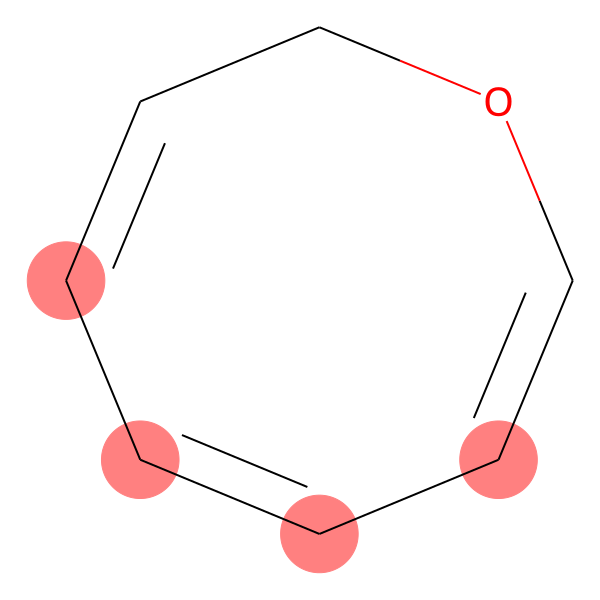

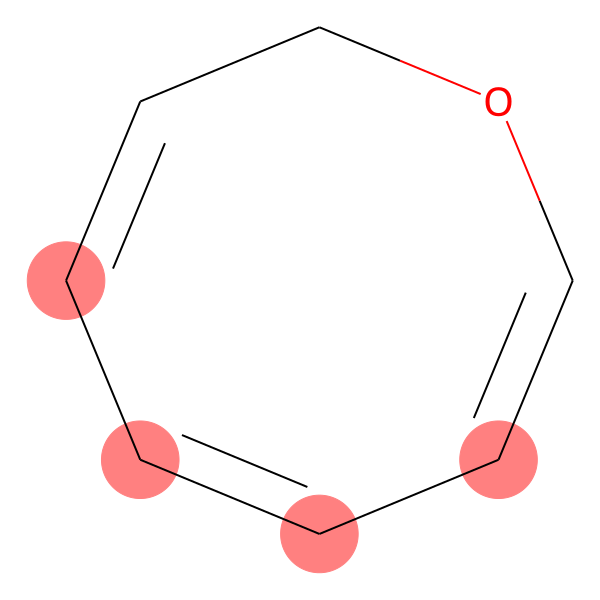

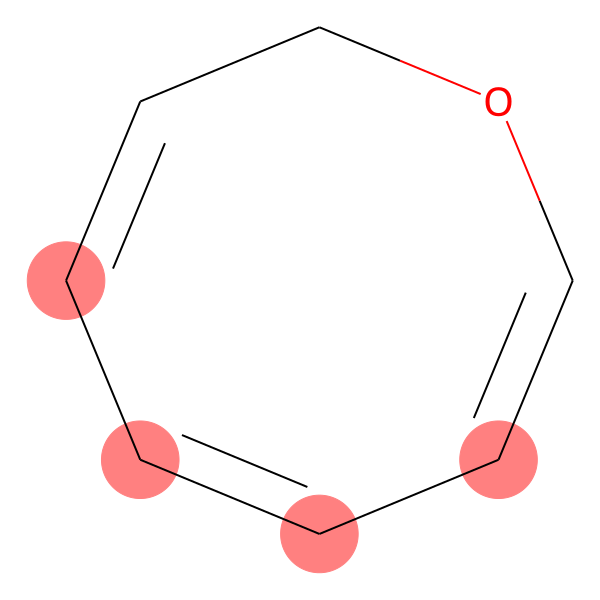

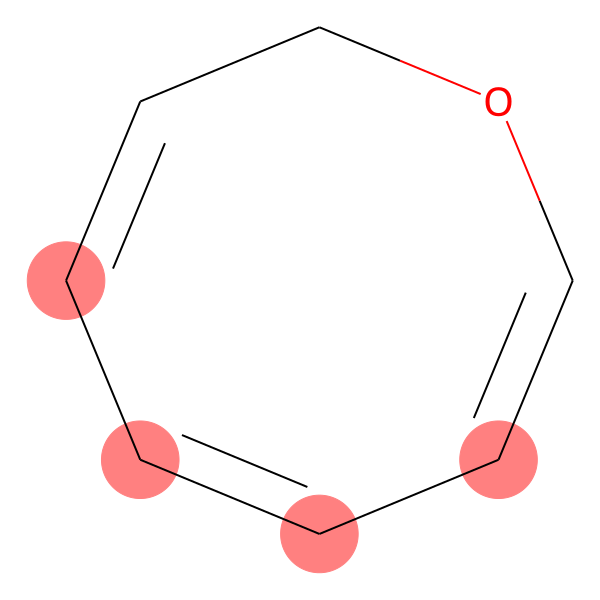

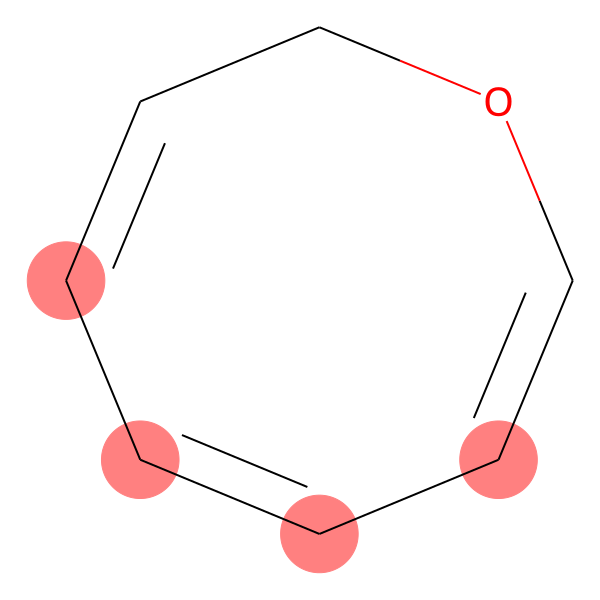

In [16]:
from IPython.display import Image

for image in image_list:
    display(img)

As we can see above, 5 out of 5 of the model's MLM predictions are chemically valid. Overall, the model seems to understand syntax with a pretty decent degree of certainity.

However, further training on a more specific dataset (say leads for a specific target) may generate a stronger chemical transformer model. Let's now fine-tune our model on a dataset of our choice, ClinTox. You can run ChemBERTa on any MoleculeNet dataset, but for the sake of convinience, we will use ClinTox as it is small and trains quickly.

### Visualizing the Attention Mechanism in ChemBERTa using BertViz

BertViz is a tool for visualizing attention in the Transformer model, supporting all models from the transformers library (BERT, GPT-2, XLNet, RoBERTa, XLM, CTRL, etc.). It extends the Tensor2Tensor visualization tool by Llion Jones and the transformers library from HuggingFace.

Using this tool, we can easily plug in ChemBERTa from the HuggingFace model hub and visualize the attention patterns produced by one or more attention heads in a given transformer layer. This is known as the attention-head view.

Lets start by obtaining a Javascript object for d3.js and jquery to create interactive visualizations:

In [17]:
%%javascript
require.config({
    paths: {
        d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
        jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
    }
});

<IPython.core.display.Javascript object>

In [18]:
def call_html():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
            requirejs.config({
                paths: {
                    base: '/static/base',
                    "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
                    jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
                },
            });
        </script>
        '''))

Now, we create an instance of ChemBERTa, tokenize a set of SMILES strings, and compute the attention for each head in the transformer. There are two available models hosted by DeepChem on HuggingFace's model hub, one being <code>seyonec/ChemBERTa-zinc-base-v1</code> which is the ChemBERTa model trained via masked lagnuage modelling (MLM) on the ZINC100k dataset, and the other being <code>seyonec/ChemBERTa-zinc250k-v1</code>, which is trained via MLM on the larger ZINC250k dataset.

In the following example, we take two SMILES molecules from the ZINC database with nearly identical chemical structure, the only difference being rooted in chiral specification (hence the additional ‘@‘ symbol). This is a feature of molecules which indicates that there exists tetrahedral centres. ‘@' tells us whether the neighbours of a molecule appear in a counter-clockwise order, whereas ‘@@‘ indicates that the neighbours are ordered in a clockwise direction. The model should ideally refer to similar substructures in each SMILES string with a higher attention weightage.

Lets look at the first SMILES string: <code>CCCCC[C@@H](Br)CC</code>:

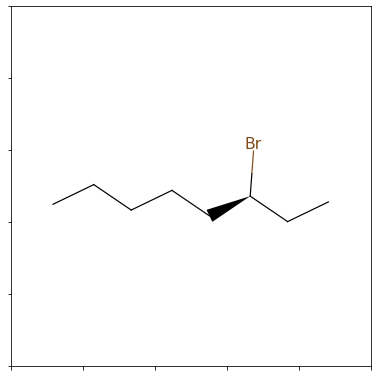

In [19]:
m = Chem.MolFromSmiles('CCCCC[C@@H](Br)CC')
fig = Draw.MolToMPL(m, size=(200, 200))

And the second SMILES string, CCCCC[C@H](Br)CC:

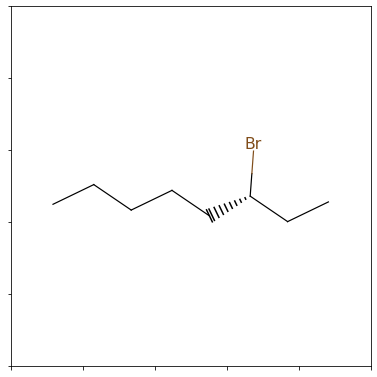

In [20]:
m = Chem.MolFromSmiles('CCCCC[C@H](Br)CC')
fig = Draw.MolToMPL(m, size=(200, 200))

The visualization below shows the attention induced by a sample input SMILES. This view visualizes attention as lines connecting the tokens being updated (left) with the tokens being attended to (right), following the design of the figures above. Color intensity reflects the attention weight; weights close to one show as very dark lines, while weights close to zero appear as faint lines or are not visible at all. The user may highlight a particular SMILES character to see the attention from that token only. This visualization is called the attention-head view. It is based on the excellent Tensor2Tensor visualization tool, and are all generated by the Bertviz library.

In [21]:
from transformers import RobertaModel, RobertaTokenizer
from bertviz import head_view

model_version = 'seyonec/PubChem10M_SMILES_BPE_450k'
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"

inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']

attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

call_html()

head_view(attention, tokens)

<IPython.core.display.Javascript object>

### What is Transfer Learning, and how does ChemBERTa utilize it?

Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

By pre-training directly on SMILES strings, and teaching ChemBERTa to recognize masked tokens in each string, the model learns a strong molecular representation. We then can take this model, trained on a structural chemistry task, and apply it to a suite of classification tasks in the MoleculeNet suite, from Tox21 to BBBP!

### Fine-tuning ChemBERTa on a Small Mollecular Dataset

Our fine-tuning dataset, ClinTox, consists of qualitative data of drugs approved by the FDA and those that have failed clinical trials for toxicity reasons.

The ClinTox dataset consists of 1478 binary labels for toxicity, using the SMILES representations for identifying molecules. The computational models produced from the dataset could become decision-making tools for government agencies in determining which drugs are of the greatest potential concern to human health. Additionally, these models can act as drug screening tools in the drug discovery pipelines for toxicity.

Let's start by importing the MolNet dataloder from bert-loves-chemistry, before importing apex and transformers, the tool which will allow us to import the ChemBERTA language model (LM) trained on PubChem-10M.

In [ ]:
%cd /content/bert-loves-chemistry

In [25]:
import os 

import numpy as np
import pandas as pd

from typing import List

# import molnet loaders from deepchem
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem

# import MolNet dataloader from bert-loves-chemistry
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

/content/bert-loves-chemistry


### But why use custom Smiles-Tokenizer's over BPE?

In this tutorial, we will be comparing the BPE tokenization algorithm with a <b>custom SmilesTokenizer</b> based on a regex pattern, which we have released as part of DeepChem. To compare tokenizers, we pretrained an identical model tokenized using this novel tokenizer, on the PubChem-1M set. The pretrained model was evaluated on the BBBP and Tox21 in the paper. We found that the SmilesTokenizer narrowly outperformed the BPE algorithm by ∆PRC-AUC = $+0.021$.

Though this result suggests that a more semantically relevant tokenization may provide performance benefits, further benchmarking on additional datasets is needed to validate this finding. <b>In this tutorial, we aim to do so, by testing this alternate model on the ClinTox dataset</b>.

Let's fetch the Smiles Tokenizer's character per line vocabulary file, which can bve loaded from the DeepChem S3 data bucket:

In [26]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt

--2021-05-12 15:10:59--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.24.176
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.24.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3524 (3.4K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>]   3.44K  --.-KB/s    in 0s      

2021-05-12 15:10:59 (162 MB/s) - ‘vocab.txt’ saved [3524/3524]



Let's use  the MolNet dataloader to generate scaffold splits from the ClinTox dataset

In [30]:
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("clintox", tasks_wanted=None)

'split' is deprecated.  Use 'splitter' instead.


Using tasks ['CT_TOX'] from available tasks for clintox: ['FDA_APPROVED', 'CT_TOX']


If you're only running the toxicity prediction portion of this tutorial, make sure you install transformers here. If you've ran all the cells before, you can ignore this install as we've already done pip install transformers before.

In [ ]:
!pip install transformers

In [32]:
train_df

text  labels
0         CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O       0
1     O=C(NCC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(N(CCO...       1
2                              Clc1cc(Cl)c(OCC#CI)cc1Cl       1
3     N#Cc1cc(NC(=O)C(=O)[O-])c(Cl)c(NC(=O)C(=O)[O-])c1       1
4                NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1       1
...                                                 ...     ...
1177                  CC(C[NH2+]C1CCCCC1)OC(=O)c1ccccc1       1
1178                CC(C(=O)[O-])c1ccc(C(=O)c2cccs2)cc1       1
1179                        CC(c1cc2ccccc2s1)N(O)C(N)=O       1
1180  CC(O)C(CO)NC(=O)C1CSSCC(NC(=O)C([NH3+])Cc2cccc...       1
1181  CC(C)OC(=O)CCC/C=C\C[C@H]1[C@@H](O)C[C@@H](O)[...       1

[1182 rows x 2 columns]

In [33]:
valid_df

text  labels
0    CC(C)OC(=O)CCC/C=C\C[C@H]1[C@@H](O)C[C@@H](O)[...       1
1    CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...       1
2    CC(C)n1c(/C=C/[C@H](O)C[C@H](O)CC(=O)[O-])c(-c...       1
3          CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)[NH+]1CCCC1       1
4    CSCC[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)...       1
..                                                 ...     ...
143  C[C@H](OC(=O)c1ccccc1)C1=CCC23OCC[NH+](C)CC12C...       1
144    C[C@@H](c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F       1
145  CC(C)C[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H]...       1
146      C[C@H](O)[C@H](O)[C@H]1CNc2[nH]c(N)nc(=O)c2N1       1
147  C[NH+]1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4C...       1

[148 rows x 2 columns]

In [34]:
test_df

text  labels
0    C[NH+]1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4C...       1
1    C[C@]1(Cn2ccnn2)[C@H](C(=O)[O-])N2C(=O)C[C@H]2...       1
2    C[NH+]1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1       1
3        Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1       1
4    OC[C@H]1O[C@@H](n2cnc3c2NC=[NH+]C[C@H]3O)C[C@@...       1
..                                                 ...     ...
143                 O=C1O[C@H]([C@@H](O)CO)C([O-])=C1O       1
144  C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H]...       1
145                       C#CC[NH2+][C@@H]1CCc2ccccc21       1
146  [H]/[NH+]=C(\N)c1ccc(OCCCCCOc2ccc(/C(N)=[NH+]/...       1
147  [H]/[NH+]=C(\N)C1=CC(=O)/C(=C\C=c2ccc(=C(N)[NH...       1

[148 rows x 2 columns]

From here, lets set up a logger to record if any issues occur, and notify us if there are any problems with the arguments we've set for the model.

In [35]:
from simpletransformers.classification import ClassificationModel
import logging

logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Now, using <code>simple-transformer</code>, let's load the pre-trained model from HuggingFace's useful model-hub. We'll set the number of epochs to 10 in the arguments, but you can train for longer, and pass early-stopping as an argument to prevent overfitting. Also make sure that <code>auto_weights</code> is set to True to do automatic weight balancing, as we are dealing with imbalanced toxicity datasets.

In [37]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', 
                            args={'evaluate_each_epoch': True,
                                  'evaluate_during_training_verbose': True,
                                  'no_save': True,
                                  'num_train_epochs': 10,
                                  'auto_weights': True})

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 and are newly initialized: ['classifier.dense.weigh

In [38]:
print(model.tokenizer)

PreTrainedTokenizerFast(name_or_path='seyonec/PubChem10M_SMILES_BPE_396_250', vocab_size=7924, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})


In [40]:
# check if our train and evaluation dataframes are set up properly
# => there should only be two columns for the SMILES string and its corresponding model
print("Train Dataset: {}".format(train_df.shape))
print("Eval Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

Train Dataset: (1182, 2)
Eval Dataset: (148, 2)
TEST Dataset: (148, 2)


Now that we've set everything up, lets get to the fun part: training the model! We use Weights and Biases, which is optional (simply remove <code>wandb_project</code> from the list of args). Its a really useful tool for monitering the model's training results (such as accuracy, learning rate and loss), alongside custom visualizations of attention and gradients.

When you run this cell, Weights and Biases will ask for an account, which you can setup through a Github account, giving you an authorization API key which you can paste into the output of the cell. Again, this is completely optional and it can be removed from the list of arguments.

In [41]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Finally, the moment we've been waiting for! Let's train the model on the train scaffold set of ClinTox, and monitor our runs using W&B. We will evaluate the performance of our model each epoch using the validation set.

In [42]:
# Create directory to store model weights (change path accordingly to where you want!)
!mkdir BPE_PubChem_10M_ClinTox_run

# Train the model
model.train_model(train_df, eval_df=valid_df, output_dir='/content/BPE_PubChem_10M_ClinTox_run', args={'wandb_project': 'project-name'})

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1182 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.
wandb: Currently logged in as: mahjouri-saamahn (use `wandb login --relogin` to force relogin)


Running Epoch 0 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to /content/BPE_PubChem_10M_ClinTox_run.


(1480, 0.1126311317070488)

In [43]:
import sklearn

# accuracy
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

# ROC-PRC
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.average_precision_score)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/148 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.421882217357801, 'tp': 137, 'tn': 3, 'fp': 6, 'fn': 2, 'auroc': 0.8337330135891288, 'auprc': 0.9852383767439764, 'acc': 0.9459459459459459, 'eval_loss': 0.2622500145306204}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/148 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.421882217357801, 'tp': 137, 'tn': 3, 'fp': 6, 'fn': 2, 'auroc': 0.8337330135891288, 'auprc': 0.9852383767439764, 'acc': 0.9577706951807671, 'eval_loss': 0.2622500145306204}


In [44]:
# Let's evaluate the model on one last string from ClinTox's test set for toxicity
# The model should predict 1
# => meaning the drug failed clinical trials for toxicity reasons and wasn't approved by the FDA

# Let's input a molecule with a toxicity value of 1
predictions, raw_outputs = model.predict(['C1=C(C(=O)NC(=O)N1)F'])

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
print(predictions)
print(raw_outputs)

[1]
[[-3.88867188  4.109375  ]]


In [46]:
# Let's compare how this model performs to a similar variant of ChemBERTa
# => that utilizes a different tokenizer, the SmilesTokenizer built-in to DeepChem
# Let's see if using a tokenizer which splites SMILES sequences into syntatically relevant chemical tokens performs differently
# => especially on molecular property prediction

# First, let's initialize this variant model
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model = ClassificationModel('roberta', 'seyonec/SMILES_tokenized_PubChem_shard00_160k', 
                            args={'evaluate_each_epoch': True,
                                  'evaluate_during_training_verbose': True,
                                  'no_save': True,
                                  'num_train_epochs': 15,
                                  'auto_weights': True})

INFO:filelock:Lock 140377221185680 acquired on /root/.cache/huggingface/transformers/30ac96f427325ec13c51dfd4507636207bdb9be77521b77ad334279cf1f5c184.f6ebc79ab803ca349ef7b469b0fbe6aa40d053e3c1c2da0501521c46c2a51bb7.lock


Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

INFO:filelock:Lock 140377221185680 released on /root/.cache/huggingface/transformers/30ac96f427325ec13c51dfd4507636207bdb9be77521b77ad334279cf1f5c184.f6ebc79ab803ca349ef7b469b0fbe6aa40d053e3c1c2da0501521c46c2a51bb7.lock
INFO:filelock:Lock 140377020839632 acquired on /root/.cache/huggingface/transformers/3a95725b53b9958c41159cd19bbde8dad8e5988ff0a6971189ef3b6b625e5f5b.ae1cdbb61878f3444ee2c5aa28dfc4577a642a31729bf0b477ccd4d948ad9081.lock


Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

INFO:filelock:Lock 140377020839632 released on /root/.cache/huggingface/transformers/3a95725b53b9958c41159cd19bbde8dad8e5988ff0a6971189ef3b6b625e5f5b.ae1cdbb61878f3444ee2c5aa28dfc4577a642a31729bf0b477ccd4d948ad9081.lock
Some weights of the model checkpoint at seyonec/SMILES_tokenized_PubChem_shard00_160k were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

Downloading:   0%|          | 0.00/8.14k [00:00<?, ?B/s]

INFO:filelock:Lock 140377000266256 released on /root/.cache/huggingface/transformers/b5b8a0f3afd321810f8ab3864fd3b562ac78b45cffd986e1fe33b0dae85e4149.dcb6a95ce7ba1c00e125887fcabb2ed5074718e901096d78d86a6d720f57db60.lock
INFO:filelock:Lock 140376851718608 acquired on /root/.cache/huggingface/transformers/e994bb60d8301b04451980e779af11e3fd55dfc1a97545f7ed9f25c4bb0144f8.0d2bc617dafe1551d37a1ee810476c86b8fcb92acede8e1ee6faf97e76000351.lock


Downloading: 0.00B [00:00, ?B/s]

INFO:filelock:Lock 140376851718608 released on /root/.cache/huggingface/transformers/e994bb60d8301b04451980e779af11e3fd55dfc1a97545f7ed9f25c4bb0144f8.0d2bc617dafe1551d37a1ee810476c86b8fcb92acede8e1ee6faf97e76000351.lock
INFO:filelock:Lock 140376865907856 acquired on /root/.cache/huggingface/transformers/186e51d9d044b8d234c30b286f58a87c44409db18948a3fd9b40fa795a4b89ad.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

INFO:filelock:Lock 140376865907856 released on /root/.cache/huggingface/transformers/186e51d9d044b8d234c30b286f58a87c44409db18948a3fd9b40fa795a4b89ad.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock
INFO:filelock:Lock 140376864261968 acquired on /root/.cache/huggingface/transformers/c9175af31705aea512d539a7e6d96803af809ba0d307eb762cb4b6a1c1af5ced.444225800184b0dbd3b86bfd798c4195c0af90f2b3b1540552cacd505c3f7c60.lock


Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

INFO:filelock:Lock 140376864261968 released on /root/.cache/huggingface/transformers/c9175af31705aea512d539a7e6d96803af809ba0d307eb762cb4b6a1c1af5ced.444225800184b0dbd3b86bfd798c4195c0af90f2b3b1540552cacd505c3f7c60.lock
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [47]:
print(model.tokenizer)

PreTrainedTokenizerFast(name_or_path='seyonec/SMILES_tokenized_PubChem_shard00_160k', vocab_size=591, model_max_len=514, is_fast=True, padding_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


In [48]:
# check if our train and evaluation dataframes are set up properly
# => there should only be two columns for the SMILES string and its corresponding label
print("Train Dataset: {}".format(train_df.shape))
print("Eval Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

Train Dataset: (1182, 2)
Eval Dataset: (148, 2)
TEST Dataset: (148, 2)


In [49]:
# Let's use Weights and Biases, a tool for monitoring the model's training results
!wandb login

wandb: Currently logged in as: mahjouri-saamahn (use `wandb login --relogin` to force relogin)


In [50]:
# Create a directory to store model weights (change path accordingly to where you want!)
!mkdir SmilesTokenizer_PubChem_10M_ClinTox_run

# Train the model
model.train_model(train_df, eval_df=valid_df, output_dir='/content/SmilesTokenizer_PubChem_10M_ClinTox_run', args={'wandb_project': 'project-name'})

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1182 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to /content/SmilesTokenizer_PubChem_10M_ClinTox_run.


(2220, 0.1132897300719419)

In [51]:
# Let's install scikit-learn to evaluate the model we've trained
# We will be using the accuracy and PRC-AUC metrics
import sklearn

# accuracy
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

# ROC-PRC
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.average_precision_score)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/148 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.3646523331752495, 'tp': 138, 'tn': 2, 'fp': 7, 'fn': 1, 'auroc': 0.8093525179856116, 'auprc': 0.9814731940782605, 'acc': 0.9459459459459459, 'eval_loss': 0.31316592873228827}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/148 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
Exception ignored in: <finalize object at 0x7fac127c99d0; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 936, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpn_reolnf'
Exception ignored in: <finalize object at 0x7fac127c9d60; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 936, in _cleanup
    _rmtree(name)
  File 

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.3646523331752495, 'tp': 138, 'tn': 2, 'fp': 7, 'fn': 1, 'auroc': 0.8093525179856116, 'auprc': 0.9814731940782605, 'acc': 0.951633958443683, 'eval_loss': 0.31316592873228827}


The model performs pretty well, averaging above 98% ROC-PRC after training on only ~1400 data samples and 150 positive leads in a couple of minutes! We can clearly see the predictive power of transfer learning, and approaches like these are becoming increasing popular in the pharmaceutical industry where larger datasets are scarce. By training on more epochs and tasks, we can probably boost the accuracy as well!

Lets evaluate the model on one last string from ClinTox's test set for toxicity. The model should predict 1, meaning the drug failed clinical trials for toxicity reasons and wasn't approved by the FDA.

In [52]:
# Let's input a molecule with a toxicity value of 1
predictions, raw_outputs = model.predict(['C1=C(C(=O)NC(=O)N1)F'])

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
print(predictions)
print(raw_outputs)

[1]
[[-4.5703125  4.53125  ]]


The model predicts the sample correctly! Some future tasks may include using the same model on multiple tasks (Tox21 provides multiple tasks relating to different biochemical pathways for toxicity, as an example), through multi-task classification, as well as training on a larger dataset such as HIV, one of the other harder tasks in molecular machine learning. This will be expanded on in future work!

## Introduction to Model Interpretability


In the previous sections, we have learned how to train models with DeepChem on a variety of applications. But we have not yet really studied the question of model explainability.

Often times when modeling we are asked the question -- How does the model work? Why should we trust this model? My response as a data scientist is usually, "because we have rigorously proved model performance on a holdout testset with splits that are realistic to the real world". Oftentimes that is not enough to convince domain experts.

LIME is a tool which can help with this problem. It uses local perturbations of feature space to determine feature importance. In this tutorial, we'll learn how to use LIME alongside DeepChem to interpret what it is our models are learning.

### Making of the Model

Let's begin by loading the Tox21 dataset with ECFP featurization. Recall how this featurization works. It identifies small fragments within each molecule, then sets elements of the output vector to 1 to indicate which fragments are present in a particular molecule.

In [54]:
import deepchem as dc

n_features = 1024

tasks,datasets, transformers = dc.molnet.load_tox21(featurization='ecfp')
train_dataset, valid_dataset, test_dataset = datasets

INFO:deepchem.molnet.load_function.molnet_loader:About to featurize tox21 dataset.
INFO:deepchem.data.data_loader:Loading raw samples now.
INFO:deepchem.data.data_loader:shard_size: 8192
INFO:deepchem.utils.data_utils:About to start loading CSV from /tmp/tox21.csv.gz
INFO:deepchem.utils.data_utils:Loading shard 1 of size 8192.
INFO:deepchem.data.data_loader:About to featurize shard.
INFO:deepchem.feat.base_classes:Featurizing datapoint 0
INFO:deepchem.feat.base_classes:Featurizing datapoint 1000
INFO:deepchem.feat.base_classes:Featurizing datapoint 2000
INFO:deepchem.feat.base_classes:Featurizing datapoint 3000
INFO:deepchem.feat.base_classes:Featurizing datapoint 4000
INFO:deepchem.feat.base_classes:Featurizing datapoint 5000
INFO:deepchem.feat.base_classes:Featurizing datapoint 6000
INFO:deepchem.feat.base_classes:Featurizing datapoint 7000
INFO:deepchem.data.data_loader:TIMING: featurizing shard 0 took 40.302 s
INFO:deepchem.data.datasets:TIMING: dataset construction took 40.388 s
I

Let's now train a model to work on this dataset. As in previous tutorials, we'll use a MultitaskClassifier, which is a simple stack of dense layers.

In [55]:
n_tasks = len(tasks)
n_features = train_dataset.get_data_shape()[0]

model = dc.models.MultitaskClassifier(n_tasks, n_features)
model.fit(train_dataset, nb_epoch=50)

INFO:deepchem.models.keras_model:Ending global_step 100: Average loss 1.41831
INFO:deepchem.models.keras_model:Ending global_step 200: Average loss 0.949752
INFO:deepchem.models.keras_model:Ending global_step 300: Average loss 0.742028
INFO:deepchem.models.keras_model:Ending global_step 400: Average loss 0.62046
INFO:deepchem.models.keras_model:Ending global_step 500: Average loss 0.572895
INFO:deepchem.models.keras_model:Ending global_step 600: Average loss 0.491958
INFO:deepchem.models.keras_model:Ending global_step 700: Average loss 0.465332
INFO:deepchem.models.keras_model:Ending global_step 800: Average loss 0.429014
INFO:deepchem.models.keras_model:Ending global_step 900: Average loss 0.396212
INFO:deepchem.models.keras_model:Ending global_step 1000: Average loss 0.374775
INFO:deepchem.models.keras_model:Ending global_step 1100: Average loss 0.354072
INFO:deepchem.models.keras_model:Ending global_step 1200: Average loss 0.33742
INFO:deepchem.models.keras_model:Ending global_step 

0.1263655662536621

Let's evaluate this model on the training and validation sets to get some basic understanding of its accuracy. We'll use the ROC-AUC as our metric of choice.

In [56]:
import numpy as np
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

print("Train scores")
print(model.evaluate(train_dataset, [metric], transformers))

print("Validation scores")
print(model.evaluate(valid_dataset, [metric], transformers))

Train scores


INFO:deepchem.metrics.metric:computed_metrics: [0.9973056385798897, 0.9977959431698988, 0.9912902477880077, 0.9944103432069913, 0.9817674671793113, 0.9969195729935166, 0.9982567850718536, 0.9679247609509527, 0.9984550098879367, 0.9934525342563123, 0.9817626867852884, 0.9961337227595287]
INFO:deepchem.metrics.metric:computed_metrics: [0.7650995195607413, 0.7960422163588391, 0.7281633967499008, 0.7083634447455585, 0.6159887005649718, 0.7160774718741425, 0.7123522802929427, 0.6599105376104345, 0.6628342245989305, 0.6546392545208513, 0.734938063063063, 0.6715442561205273]


{'mean-roc_auc_score': 0.9912895593857907}
Validation scores
{'mean-roc_auc_score': 0.7021627805050752}


### Using LIME

The model seems to do a reasonable job of predicting which molecules are toxic, but how does it work? When it predicts that a particular molecule is toxic or non-toxic, what aspects of the molecule led to that prediction? This is the essence of <i>explainability</i>: learning why an input led to a certain prediction.

LIME is a tool for addressing this problem. The name is short for "Local Interpretable Model-Agnostic Explanations". It can work on any problem with a fixed size input vector. It works by computing probability distributions for the individual features and the covariance between the features. This allows it to construct a local linear model in the neighborhood of a sample, describing what local perturbations of the input would have the biggest effect on the output. That is, what fragments added to or removed from the molecule would be most likely to change the prediction between toxic and non-toxic?

First we need to install lime. Luckily, lime is conveniently available on pip, so you can install it from within this Jupyter notebook.

In [57]:
!pip install lime

     |████████████████████████████████| 276kB 6.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=7939e5ca8d5a5f0b4af9999f18c1d9360d1514e51f505a742a24b2ac5ff9aa54
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


Now that we have lime installed, we want to create an <code>Explainer</code> object for <code>lime</code>. This object will take in the training dataset and names for the features. We're using circular fingerprints as our features. We don't have natural names for our features, so we just number them numerically. On the other hand, we do have natural names for our labels. Recall that Tox21 is for toxicity assays; so let's call 0 as 'not toxic' and 1 as 'toxic'.

In [58]:
from lime import lime_tabular

feature_names = ["fp_%s" % x for x in range(1024)]
explainer = lime_tabular.LimeTabularExplainer(train_dataset.X,
                                              feature_names=feature_names,
                                              categorical_features=feature_names,
                                              class_names=['not toxic', 'toxic'],
                                              discretize_continuous=True)

We are going to attempt to explain why the model predicts a molecule to be toxic for NR-AR. The specific assay details can be found here.

In [59]:
# We need a function which takes a 2d numpy array and returns predictions
def eval_model(my_model):
    def eval_closure(x):
        ds = dc.data.NumpyDataset(x, n_tasks=12)
        # The 0th task is NR-AR
        predictions = my_model.predict(ds)[:,0]
        return predictions
    return eval_closure

model_fn = eval_model(model)

Let's now attempt to use this evaluation function on a specific molecule. Let's pick the first molecule in the test set that is correctly predicted to be toxic (that is, the molecule is toxic, and the model correctly predicts it to be toxic).

In [60]:
from rdkit import Chem

active_id = np.where((test_dataset.y[:,0] == 1) * (model.predict(test_dataset)[:,0,1] > 0.8))[0][0]
Chem.MolFromSmiles(test_dataset.ids[active_id])

Now that we have a trained model and a molecule, let's ask the <code>Explainer</code> to figure out why the molecule was predicted to be toxic. We ask it for the 100 features (that is, elements in the fingerprint, each corresponding to one or more fragments) the prediction is most sensitive to.

In [61]:
exp = explainer.explain_instance(test_dataset.X[active_id], model_fn, num_features=100, top_labels=1)

The returned value is an <code>Explanation</code> object. It has methods you can call to retrieve the results in various forms. A convenient form for working interactively is <code>show_in_notebook()</code>, providing a graphical representation.

In [62]:
exp.show_in_notebook(show_table=True, show_all=False)

This output needs some explanation. On the left it shows that this molecule is predicted to be toxic. We already knew that of course. That's why we chose it. On the right it lists the 100 elements of the fingerprint with the most influence on the prediction. For each one, the value column indicates whether the corresponding fragment is present (1.00) or not (0.00) in this molecule. And in the middle it shows whether the value for each index contributes to the prediction being for non-toxic (blue) or toxic (orange).

Most of the fragments are not present. It's telling us about fragments that, if they were present, would shift the prediction. We aren't very interested in those. We want to know about the fragments that are present in the molecule that are contributing to the prediction. Let's try to put these results into a more useful form.

To start, indices within the fingerprint aren't very informative. Let's write a function to reverse the featurization, mapping from indices back to the fragments that activated them.

In [63]:
def fp_mol(mol, fp_length=1024):
    """
    returns: dict of <int:list of string>
        dictionary mapping fingerprint index
        to list of SMILES strings that activated that fingerprint
    """
    d = {}
    feat = dc.feat.CircularFingerprint(sparse=True, smiles=True, size=1024)
    retval = feat._featurize(mol)
    for k, v in retval.items():
        index = k % fp_length
        if index not in d:
            d[index] = set()
        d[index].add(v['smiles'])
    return d

# What fragments activated what fingerprints in our active molecule?
my_fragments = fp_mol(Chem.MolFromSmiles(test_dataset.ids[active_id]))

Now we want to query the <code>Explanation</code> to see which of those fragments contributed to the prediction. We can use the <code>as_map()</code> method to get the information in a form more suitable for processing.

In [65]:
print(exp.as_map())

{1: [(907, -0.37169793779580995), (627, -0.26428775044437897), (827, -0.18772266977512708), (445, -0.17701123608112485), (279, -0.17695818614110786), (359, -0.16647621277189192), (751, -0.16500689387200004), (693, -0.1544927223862665), (57, -0.15362134023933854), (755, -0.1486883260240763), (28, -0.13388115548630966), (5, -0.13331093205465874), (411, -0.13219187374544925), (269, -0.130535708545757), (1021, -0.12987556243491186), (554, -0.12879974227776378), (396, -0.1245115010718951), (151, -0.12318831359830107), (632, -0.12183339441611396), (405, 0.12119068104222905), (1003, -0.12068802102133451), (830, -0.12015244776055245), (381, -0.11932368681188896), (296, -0.11926789905277772), (918, -0.11908401170147152), (542, -0.11562679335755585), (956, -0.1148300837068818), (752, -0.11395710719774652), (717, -0.11368598725428765), (538, -0.11142054427076091), (267, -0.10951185267603086), (999, -0.10904639248271739), (7, -0.10815878507488147), (735, 0.1074516059730374), (742, -0.1067397376129

The keys in this map are the labels, of which we only have one. The value is a list of tuples, each of the form (fingerprint_index, weight). Let's convert it to a dict mapping indices to weights.

In [66]:
fragment_weight = dict(exp.as_map()[1])

We know which fragments are present in our molecule of interest (<code>my_fragments</code>), and we know which fragments contributed to the prediction (<code>fragment_weights</code>). Let's loop over them and print them out.

In [68]:
for index in my_fragments:
    if index in fragment_weight:
        print(index, my_fragments[index], fragment_weight[index])

555 {'C[C@](C)(C)CCC'} 0.10599165413376703
1006 {'C[C@](C)(O)CCC'} 0.08649715375166449
84 {'C=CC'} 0.08444343208258762
519 {'C[C@H](C)C'} 0.0912557004510562
529 {'CCC[C@H](C)C'} 0.0825239662659787
735 {'CC(=C)C=CC'} 0.1074516059730374


These are the fragments most responsible for the prediction.

## Synthetic Feasibility

Synthetic feasibility is a problem when running large scale enumerations. Often molecules that are enumerated are very difficult to make and thus not worth inspection, even if their other chemical properties are good in silico. This section goes through how to train the ScScore model.

The idea of the model is to train on pairs of molecules where one molecule is "more complex" than the other. The neural network then can make scores which attempt to keep this pairwise ordering of molecules. The final result is a model which can give a relative complexity of a molecule.

The paper trains on every reaction in reaxys, declaring products more complex than reactions. Since this training set is prohibitively expensive we will instead train on arbitrary molecules declaring one more complex if its SMILES string is longer. In the real world you can use whatever measure of complexity makes sense for the project.

In this tutorial, we'll use the Tox21 dataset to train our simple synthetic feasibility model.

### Make The Datasets

Let's begin by loading some molecules to work with. We load Tox21, specifying splitter=None so everything will be returned as a single dataset.

In [69]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='Raw', splitter=None)
molecules = datasets[0].X

INFO:deepchem.molnet.load_function.molnet_loader:About to featurize tox21 dataset.
INFO:deepchem.data.data_loader:Loading raw samples now.
INFO:deepchem.data.data_loader:shard_size: 8192
INFO:deepchem.utils.data_utils:About to start loading CSV from /tmp/tox21.csv.gz
INFO:deepchem.utils.data_utils:Loading shard 1 of size 8192.
INFO:deepchem.data.data_loader:About to featurize shard.
INFO:deepchem.feat.base_classes:Featurizing datapoint 0
INFO:deepchem.feat.base_classes:Featurizing datapoint 1000
INFO:deepchem.feat.base_classes:Featurizing datapoint 2000
INFO:deepchem.feat.base_classes:Featurizing datapoint 3000
INFO:deepchem.feat.base_classes:Featurizing datapoint 4000
INFO:deepchem.feat.base_classes:Featurizing datapoint 5000
INFO:deepchem.feat.base_classes:Featurizing datapoint 6000
INFO:deepchem.feat.base_classes:Featurizing datapoint 7000
INFO:deepchem.data.data_loader:TIMING: featurizing shard 0 took 8.461 s
INFO:deepchem.data.datasets:TIMING: dataset construction took 8.701 s
INF

Because ScScore is trained on relative complexities, we want the X tensor in our dataset to have 3 dimensions (<code>sample_id, molecule_id, features</code>). The <code>molecule_id</code> dimension has size 2 because a sample is a pair of molecules. The label is 1 if the first molecule is more complex than the second molecule. The function <code>create_dataset</code> we introduce below pulls random pairs of SMILES strings out of a given list and ranks them according to this complexity measure.

In the real world you could use purchase cost, or number of reaction steps required as your complexity score.

In [76]:
from rdkit import Chem
import random

from deepchem.feat import CircularFingerprint
import numpy as np

def create_dataset(fingerprints, smiles_lens, ds_size=100000):
    X, y = [], []
    all_data = list(zip(fingerprints, smiles_lens))
    while len(y) < ds_size:
        i1 = random.randrange(0, len(smiles_lens))
        i2 = random.randrange(0, len(smiles_lens))
        m1 = all_data[i1]
        m2 = all_data[i2]
        if m1[1] == m2[1]:
            continue
        if m1[1] > m2[1]:
            y.append(1.0)
        else:
            y.append(0.0)
        X.append([m1[0], m2[0]])
    return dc.data.NumpyDataset(np.array(X), np.expand_dims(np.array(y), axis=1))

With our complexity ranker in place we can now construct our dataset. Let's start by randomly splitting the list of molecules into training and test sets.

In [77]:
molecule_ds = dc.data.NumpyDataset(np.array(molecules))
splitter = dc.splits.RandomSplitter()
train_mols, test_mols = splitter.train_test_split(molecule_ds)

INFO:deepchem.splits.splitters:Computing train/valid/test indices


We'll featurize all our molecules with the ECFP fingerprint with chirality (matching the source paper), and will then construct our pairwise dataset using the function defined above.

In [78]:
n_features = 1024
featurizer = dc.feat.CircularFingerprint(size=n_features, radius=2, chiral=True)

train_features = featurizer.featurize(train_mols.X)
train_smiles_len = [len(Chem.MolToSmiles(x)) for x in train_mols.X]
train_dataset = create_dataset(train_features, train_smiles_len)

INFO:deepchem.feat.base_classes:Featurizing datapoint 0
INFO:deepchem.feat.base_classes:Featurizing datapoint 1000
INFO:deepchem.feat.base_classes:Featurizing datapoint 2000
INFO:deepchem.feat.base_classes:Featurizing datapoint 3000
INFO:deepchem.feat.base_classes:Featurizing datapoint 4000
INFO:deepchem.feat.base_classes:Featurizing datapoint 5000
INFO:deepchem.feat.base_classes:Featurizing datapoint 6000


Now that we have our dataset created, let's train a <code>ScScoreModel</code> on this dataset.

In [79]:
model = dc.models.ScScoreModel(n_features=n_features)
model.fit(train_dataset, nb_epoch=20)

INFO:deepchem.models.keras_model:Ending global_step 100: Average loss 0.354686
INFO:deepchem.models.keras_model:Ending global_step 200: Average loss 0.26844
INFO:deepchem.models.keras_model:Ending global_step 300: Average loss 0.235736
INFO:deepchem.models.keras_model:Ending global_step 400: Average loss 0.215105
INFO:deepchem.models.keras_model:Ending global_step 500: Average loss 0.183265
INFO:deepchem.models.keras_model:Ending global_step 600: Average loss 0.18648
INFO:deepchem.models.keras_model:Ending global_step 700: Average loss 0.178118
INFO:deepchem.models.keras_model:Ending global_step 800: Average loss 0.164893
INFO:deepchem.models.keras_model:Ending global_step 900: Average loss 0.167417
INFO:deepchem.models.keras_model:Ending global_step 1000: Average loss 0.160431
INFO:deepchem.models.keras_model:Ending global_step 1100: Average loss 0.113677
INFO:deepchem.models.keras_model:Ending global_step 1200: Average loss 0.122447
INFO:deepchem.models.keras_model:Ending global_step

0.03627755403518677

### Model Performance

Lets evaluate how well the model does on our holdout molecules. The SaScores should track the length of SMILES strings from never before seen molecules.

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
mol_scores = model.predict_mols(test_mols.X)
smiles_length = [len(Chem.MolToSmiles(x)) for x in test_mols.X]

INFO:deepchem.feat.base_classes:Featurizing datapoint 0
INFO:deepchem.feat.base_classes:Featurizing datapoint 1000


Let's now plot the length of the smiles string of the molecule against the SaScore using matplotlib.

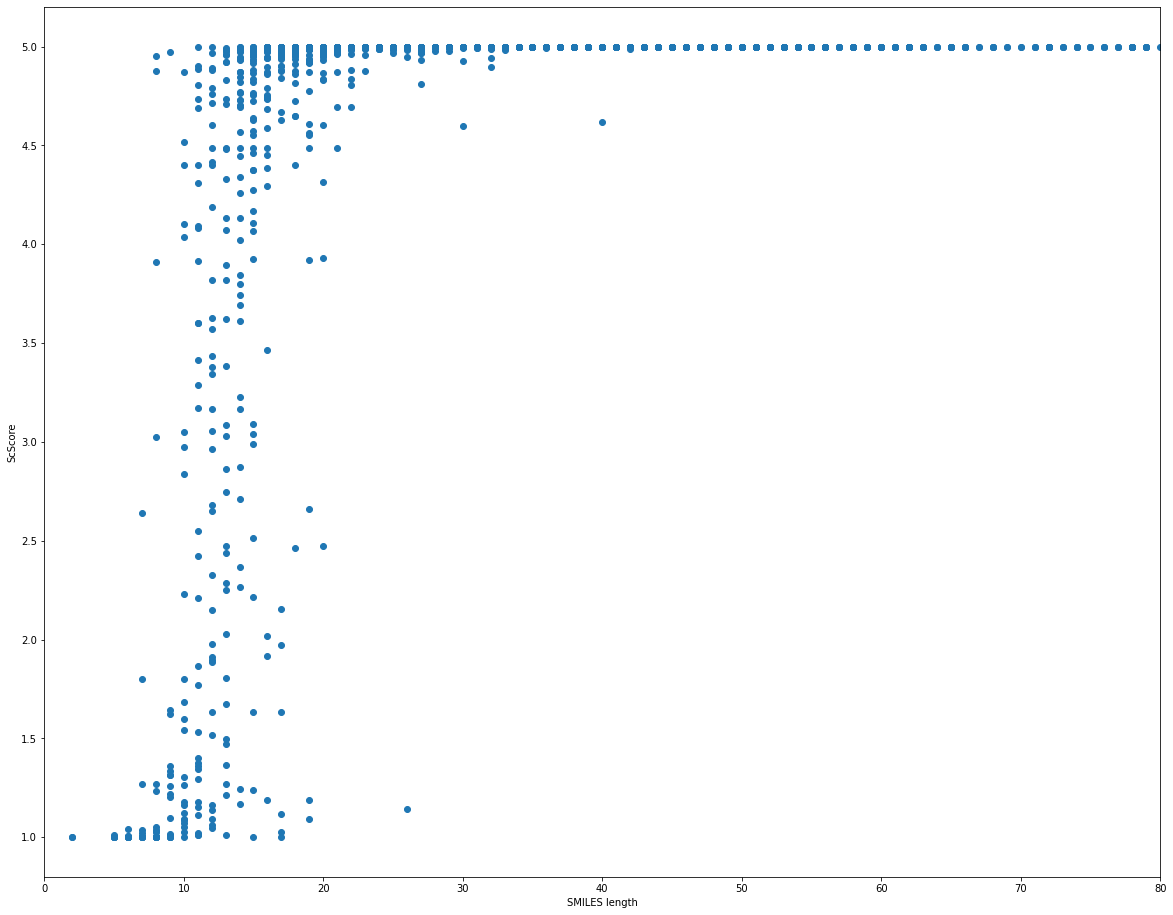

In [83]:
plt.figure(figsize=(20,16))
plt.scatter(smiles_length, mol_scores)
plt.xlim(0,80)
plt.xlabel("SMILES length")
plt.ylabel("ScScore")
plt.show()

As we can see the model generally tracks SMILES length. It has good enrichment between 8 and 30 characters and gets both small and large SMILES strings extremes dead on.

Now you can train your own models on more meaningful metrics than SMILES length!

## Calculating Atomic Contributions for Molecules Based on a Graph Convolutional QSAR Model

In an earlier tutorial we introduced the concept of model interpretability: understanding why a model produced the result it did. In this tutorial we will learn about atomic contributions, a useful tool for interpreting models that operate on molecules.

The idea is simple: remove a single atom from the molecule and see how the model's prediction changes. The "atomic contribution" for an atom is defined as the difference in activity between the whole molecule, and the fragment remaining after atom removal. It is a measure of how much that atom affects the prediction.

Contributions are also known as "attributions", "coloration", etc. in the literature. This is a model interpretation method [1], analogous to Similarity maps [2] in the QSAR domain, or occlusion methods in other fields (image classification, etc).

### A classification QSAR model for blood-brain barrier permeability

BBB permeability is the ability of compounds to enter the central nervous system. Here we use a dataset of relatively small compounds which are transported by diffusion without any carriers. The property is defined as log10(concentration in brain / concentration in blood). Compounds with a positive value (and 0) are labeled active, and others are labeled inactive. After modelling we will identify atoms favorable and unfavorable for diffusion.

First let's create the dataset. The molecules are stored in an SDF file.

In [11]:
import pandas as pd
import deepchem as dc
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase

from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf

# !wget https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/atomic_contributions_tutorial_data/logBB.sdf

DATASET_FILE = 'logBB.sdf'
# Create RDKit mol objects, since we will need them later
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None]
loader = dc.data.SDFLoader(tasks=["logBB_class"],
                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)

Now let's build and train a <code>GraphConvModel</code>.

In [12]:
np.random.seed(2020)
tf.random.set_seed(2020)

In [13]:
m = dc.models.GraphConvModel(1, mode="classification", batch_normalize=False, batch_size=100)
m.fit(dataset, nb_epoch=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.5347206115722656

Let's load a test set and see how well it works.

In [14]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/atomic_contributions_tutorial_data/logBB_test_.sdf

TEST_DATASET_FILE = "logBB_test_.sdf"
loader = dc.data.SDFLoader(tasks=["p_np"], sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer())
test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)

pred = m.predict(test_dataset)
pred = np.argmax(np.squeeze(pred), axis=1)

ba = metrics.balanced_accuracy_score(y_true=test_dataset.y, y_pred=pred)
print(ba)

--2021-05-12 22:33:42--  https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/atomic_contributions_tutorial_data/logBB_test_.sdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81179 (79K) [text/plain]
Saving to: ‘logBB_test_.sdf’

logBB_test_.sdf     100%[===================>]  79.28K  --.-KB/s    in 0.02s   

2021-05-12 22:33:42 (3.42 MB/s) - ‘logBB_test_.sdf’ saved [81179/81179]

0.7611111111111111


The balanced accuracy is high enough. Now let's proceed to model interpretation and estimate the contributions of individual atoms to the prediction.

### A fragment dataset

Now let's prepare a dataset of fragments based on the training set. (Any other unseen data set of interest can also be used). These fragments will be used to evaluate the contributions of individual atoms.

For each molecule we will generate a list of ConvMol objects. Specifying <code>per_atom_fragmentation=True</code> tells it to iterate over all heavy atoms and featurize a single-atom-depleted version of the molecule with each one removed.

In [15]:
loader = dc.data.SDFLoader(tasks=[],
                           featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True),
                           sanitize=True)
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/deepchem/data/data_loader.py:866: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(features), valid_inds


The dataset still has the same number of samples as the original training set, but each sample is now represented as a list of ConvMol objects (one for each fragment) rather than a single ConvMol.

IMPORTANT: The order of fragments depends on the input format. If SDF, the fragment order is the same as the atom order in corresponding mol blocks. If SMILES (i.e. csv with molecules represented as SMILES), then the order is given by RDKit CanonicalRankAtoms

In [16]:
print(frag_dataset.X.shape)

(298,)


We really want to treat each fragment as a separate sample. We can use a FlatteningTransformer to flatten the fragments lists.

In [17]:
tr = dc.trans.FlatteningTransformer(frag_dataset)
frag_dataset = tr.transform(frag_dataset)
print(frag_dataset.X.shape)

(5111,)


### Predicting atomic contributions to activity

Now we will predict the activity for molecules and for their fragments. Then, for each fragment, we'll find the activity difference: the change in activity when removing one atom.

Note: Here, in classification context, we use the probability output of the model as the activity. So the contribution is the probability difference, i.e. "how much a given atom increases/decreases the probability of the molecule being active."

In [18]:
# whole molecules
pred = np.squeeze(m.predict(dataset))[:, 1] # probability of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"]) # turn to dataframe for convenience

# fragments
pred_frags = np.squeeze(m.predict(frag_dataset))[:, 1]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])

We take the difference to find the atomic contributions.

In [19]:
# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

In [20]:
df

Fragment  Molecule   Contrib
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.752452  0.813709  0.061256
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.742829  0.813709  0.070880
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.744098  0.813709  0.069610
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.819543  0.813709 -0.005835
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.746416  0.813709  0.067292
...                                              ...       ...       ...
c1cncc(C2CCCN2)c1                           0.773834  0.808046  0.034212
c1cncc(C2CCCN2)c1                           0.724988  0.808046  0.083059
c1cncc(C2CCCN2)c1                           0.713477  0.808046  0.094569
c1cncc(C2CCCN2)c1                           0.686773  0.808046  0.121274
c1cncc(C2CCCN2)c1                           0.661931  0.808046  0.146116

[5111 rows x 3 columns]

We can use the SimilarityMaps feature of RDKit to visualize the results. Each atom is colored by how it affects activity.

In [24]:
def vis_contribs(mols, df, smi_or_sdf = "sdf"):
    # input format of file, which was used to create dataset determines the order of atoms,
    # so we take it into account for correct mapping!
    maps = []
    for mol in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n, atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":
            for n, atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps

Let's look at some pictures:

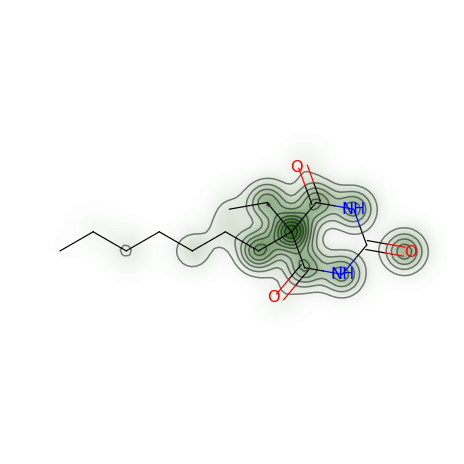

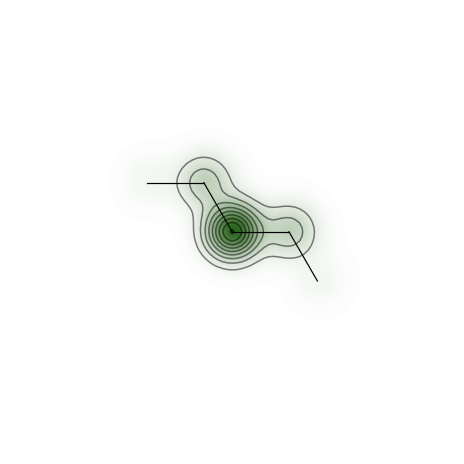

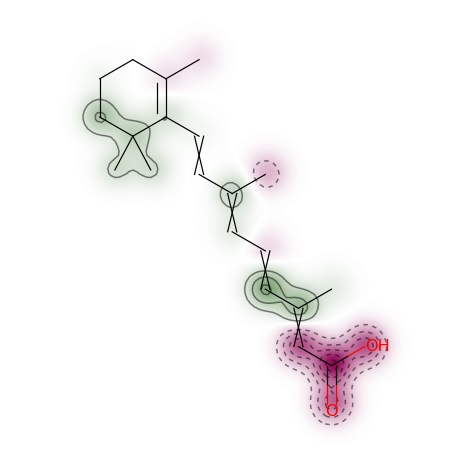

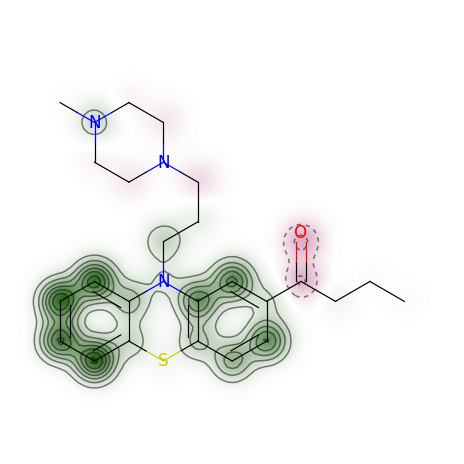

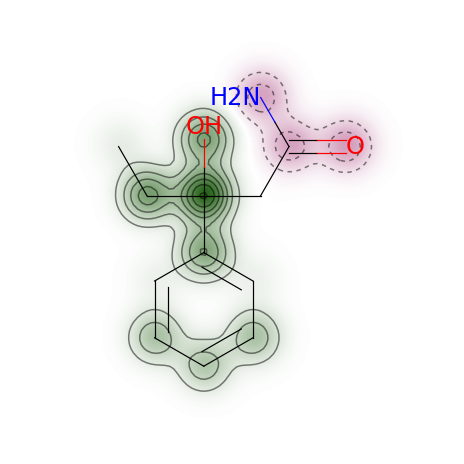

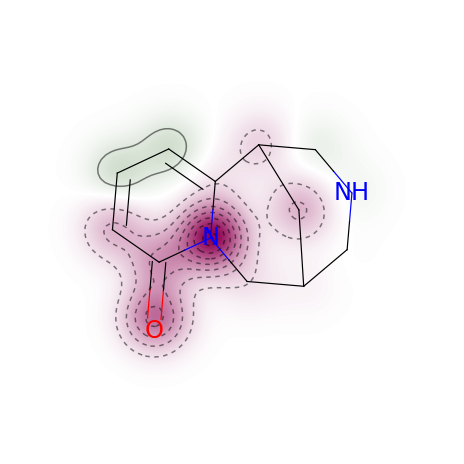

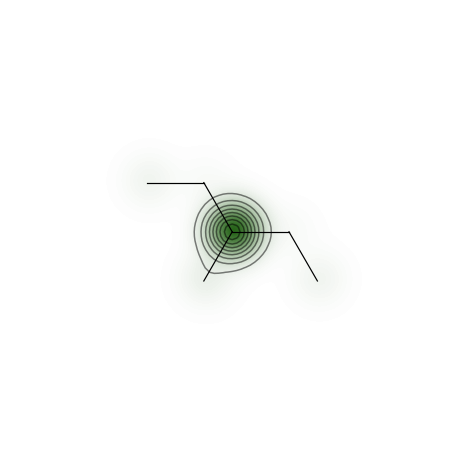

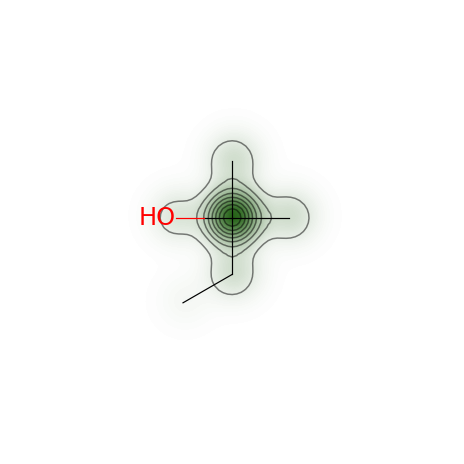

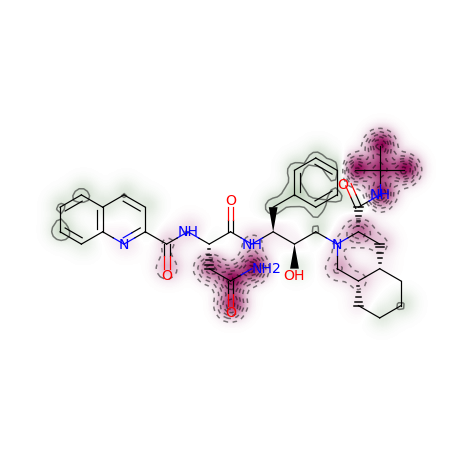

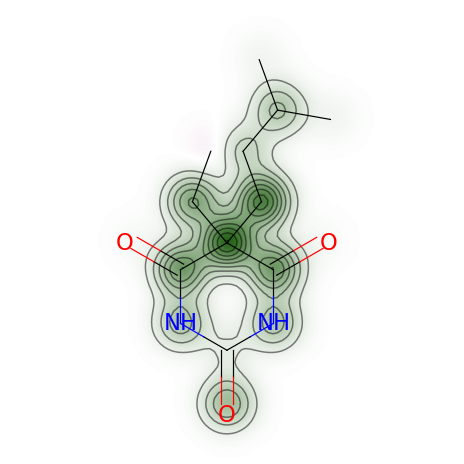

In [25]:
np.random.seed(2000)
maps = vis_contribs(np.random.choice(np.array(mols),10), df)

We can see that aromatics or aliphatics have a positive impact on blood-brain barrier permeability, while polar or charged heteroatoms have a negative influence. This is generally consistent with literature data.

### A regression task

The example above used a classification model. The same techniques can also be used for regression models. Let's look at a regression task, aquatic toxicity (towards the water organism T. pyriformis).

Toxicity is defined as log10(IGC50) (concentration that inhibits colony growth by 50%). Toxicophores for T. pyriformis will be identified by atomic contributions.

All the above steps are the same: load data, featurize, build a model, create dataset of fragments, find contributions, and visualize them.

Note: this time as it is regression, contributions will be in activity units, not probability.

In [26]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Work_set_OCHEM.sdf
DATASET_FILE = 'Tetrahymena_pyriformis_Work_set_OCHEM.sdf'

# create RDKit mol objects, we will need them later
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None]
loader = dc.data.SDFLoader(tasks=["IGC50"],
                           featurizer=dc.feat.ConvMolFeaturizer(), sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

--2021-05-12 22:50:23--  https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Work_set_OCHEM.sdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1672463 (1.6M) [text/plain]
Saving to: ‘Tetrahymena_pyriformis_Work_set_OCHEM.sdf’

Tetrahymena_pyrifor 100%[===================>]   1.59M  --.-KB/s    in 0.1s    

2021-05-12 22:50:24 (11.2 MB/s) - ‘Tetrahymena_pyriformis_Work_set_OCHEM.sdf’ saved [1672463/1672463]



Create and train the model.

In [27]:
np.random.seed(2020)
tf.random.set_seed(2020)

m = dc.models.GraphConvModel(1, mode="regression", batch_normalize=False)
m.fit(dataset, nb_epoch=40)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.12106765747070312

Load the test dataset and check the model's performance.

In [28]:
# Load the test dataset and check the model's performance
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Test_set_OCHEM.sdf
TEST_DATASET_FILE = 'Tetrahymena_pyriformis_Test_set_OCHEM.sdf'

loader = dc.data.SDFLoader(tasks=["IGC50"], sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer())
test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)

pred = m.predict(test_dataset)
mse = metrics.mean_squared_error(y_true=test_dataset.y, y_pred=pred)
r2 = metrics.r2_score(y_true=test_dataset.y, y_pred=pred)

print(mse)
print(r2)

--2021-05-12 22:55:26--  https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Test_set_OCHEM.sdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 417383 (408K) [text/plain]
Saving to: ‘Tetrahymena_pyriformis_Test_set_OCHEM.sdf’

Tetrahymena_pyrifor 100%[===================>] 407.60K  --.-KB/s    in 0.06s   

2021-05-12 22:55:27 (6.29 MB/s) - ‘Tetrahymena_pyriformis_Test_set_OCHEM.sdf’ saved [417383/417383]

0.23879228243122572
0.7837783479046575


Load the training set again, but this time set <code>per_atom_fragmentation=True</code>.

In [29]:
# Load the training set again, but this time per_atom_fragmentation=True
loader = dc.data.SDFLoader(tasks=[], # don't need any task
                           sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True))

frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)
tr = dc.trans.FlatteningTransformer(frag_dataset) # flatten dataset and add ids to each fragment
frag_dataset = tr.transform(frag_dataset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/deepchem/data/data_loader.py:866: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(features), valid_inds


Compute the activity differences.

In [31]:
# whole molecules
pred = m.predict(dataset)
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"]) # turn to dataframe for convenience

# fragments
pred_frags = m.predict(frag_dataset)
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"]) # turn to dataframe for convenience

# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

Lets take some molecules with moderate activity (not extremely active/inactive) and visualize the atomic contributions.

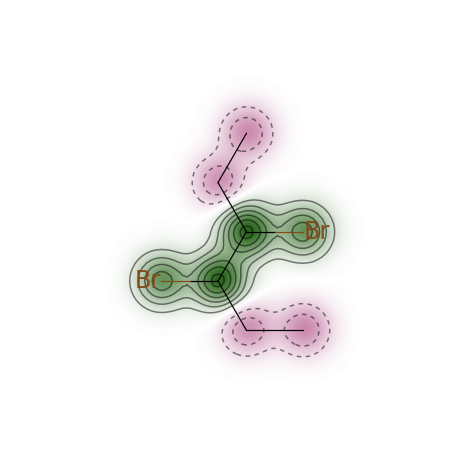

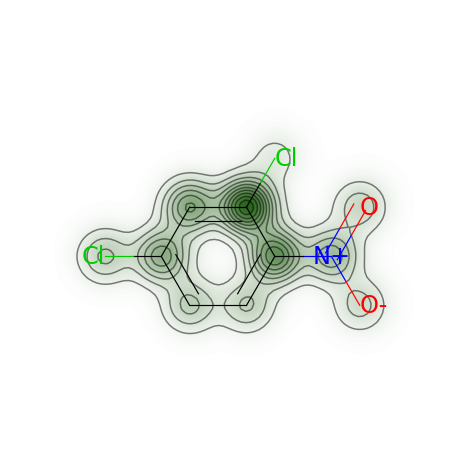

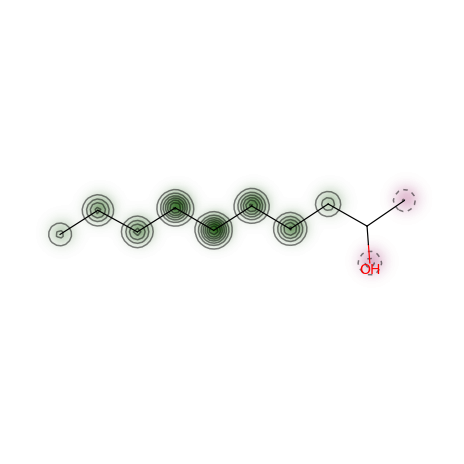

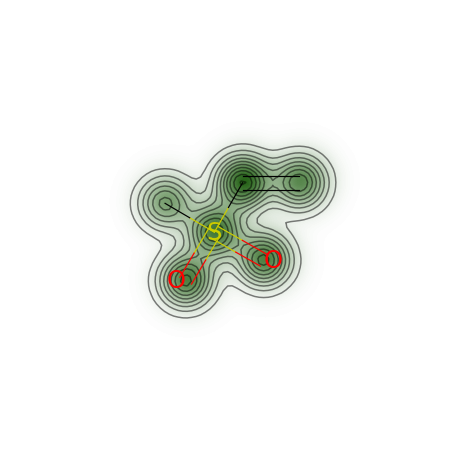

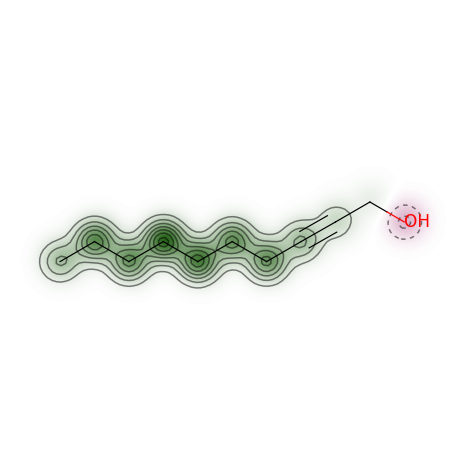

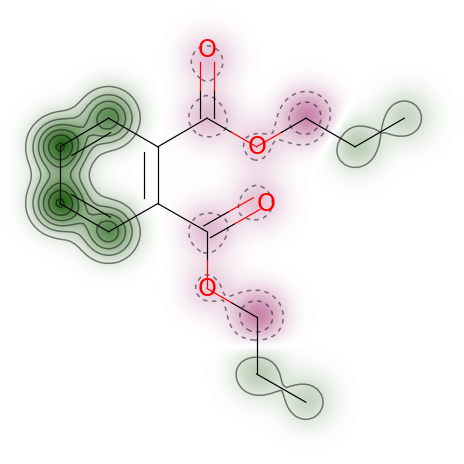

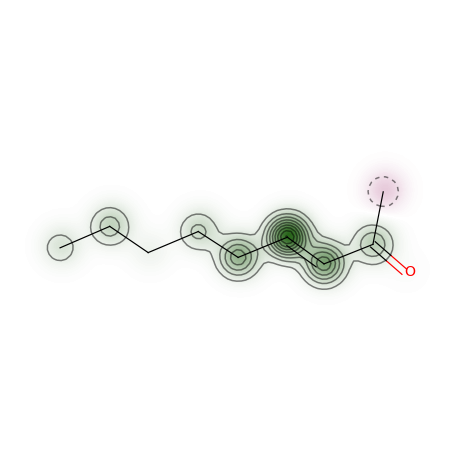

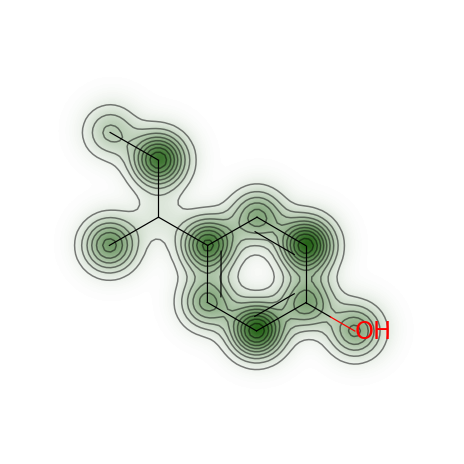

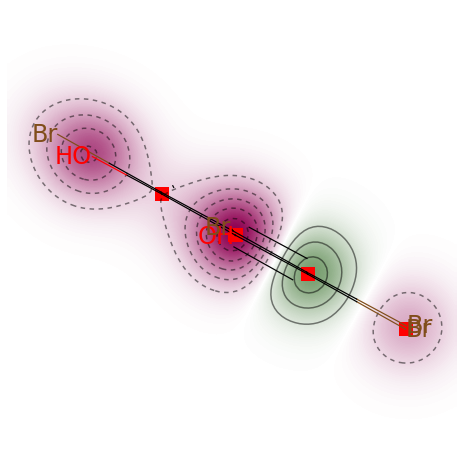

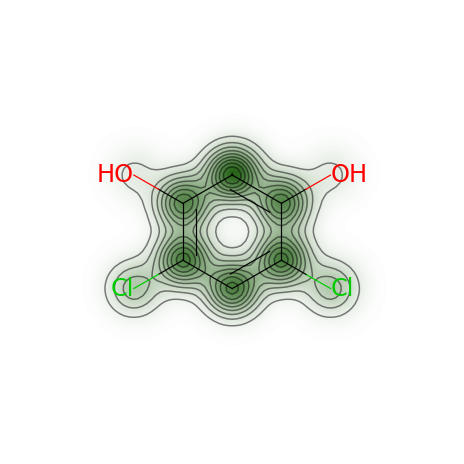

In [33]:
maps = vis_contribs([mol for mol in mols if float(mol.GetProp("IGC50"))>3 and float(mol.GetProp("IGC50"))<4][:10], df)